In [1288]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf # predictive modeling with nice outputs

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os #importing the kaggle input
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [1289]:
import pandas as pd #essential importing packages
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax, norm, skew

import warnings
warnings.filterwarnings("ignore") #initiating the warnings

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 5000) #inputing the displays

Exploring the data by diving them and importing the data into train and test split for better prediction.

In [1290]:
# Load the data set and reading the datasets
train_dat = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_dat = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
sample_submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

In [1291]:
train_dat.info() #datatypes and information
train_dat = train_dat.drop(['Id'], axis=1)
#test_dat = test_dat.drop(['Id'], axis=1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

1.HANDLING MISSING VALUES FOR CLEANING THE DATA

In [1292]:
# calculating the missing values and missing % of data.
mis_val = pd.DataFrame(train_dat.isna().sum(), columns=['Sum'])
mis_val = mis_val.sort_values(by = ['Sum'], ascending=False)
mis_val = mis_val[mis_val['Sum']>0]
mis_val['Percent'] = mis_val['Sum']/1460*100
mis_val

Sum    Percent
PoolQC        1453  99.520548
MiscFeature   1406  96.301370
Alley         1369  93.767123
Fence         1179  80.753425
FireplaceQu    690  47.260274
LotFrontage    259  17.739726
GarageYrBlt     81   5.547945
GarageCond      81   5.547945
GarageType      81   5.547945
GarageFinish    81   5.547945
GarageQual      81   5.547945
BsmtExposure    38   2.602740
BsmtFinType2    38   2.602740
BsmtCond        37   2.534247
BsmtQual        37   2.534247
BsmtFinType1    37   2.534247
MasVnrArea       8   0.547945
MasVnrType       8   0.547945
Electrical       1   0.068493

A scatter plot display the relationship between two variables. In a scatter plot, each point on the graph represents a data point in the dataset, where the x-axis represents one variable and the y-axis represents the other variable. Scatter plots can be used to identify patterns and relationships between variables, which can help with data cleaning and feature engineering. Scatter plots can be used to evaluate the performance of machine learning models. For example, if a scatter plot shows a strong linear relationship between the predicted values and the actual values, this suggests that the model is performing well. Scatter plots can be used to identify outliers, which are data points that are significantly different from the rest of the data.

<AxesSubplot:xlabel='Alley', ylabel='SalePrice'>

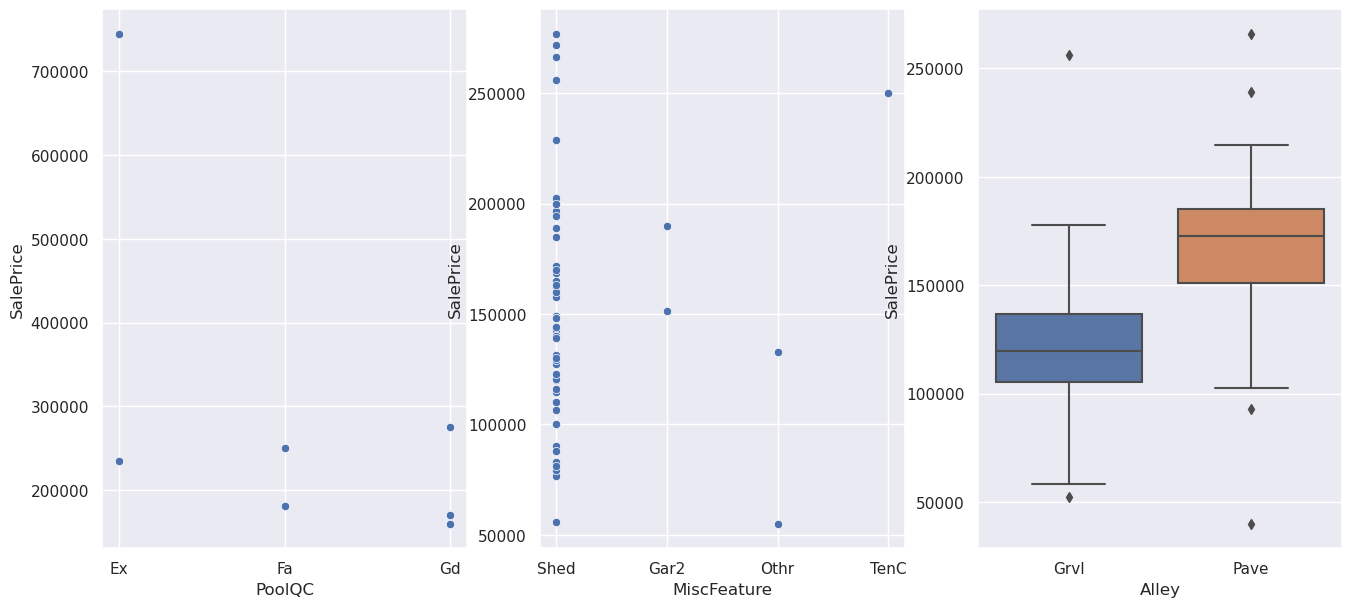

In [1293]:
#displaying the scatter plot and the box plot
fig, ax = plt.subplots(1,3, figsize =(16, 7))
sns.scatterplot(x= train_dat['PoolQC'], y=train_dat['SalePrice'], ax=ax[0])
sns.scatterplot(x= train_dat['MiscFeature'], y=train_dat['SalePrice'], ax=ax[1])
sns.boxplot(x= train_dat['Alley'], y=train_dat['SalePrice'], ax=ax[2]) #setting the box plot with the sale price

the above charts are displaying housing features and their corresponding sale prices.

The first scatter plot displays the relationship between 'PoolQC' (quality of pool) and 'SalePrice'. The plot shows that as the quality of the pool increases, the sale price also tends to increase. However, the plot also shows that there are relatively few data points where 'PoolQC' is greater than zero (meaning that the property has a pool), which may limit the generalizability of this relationship.

The second scatter plot displays the relationship between 'MiscFeature' (other miscellaneous features not covered in other categories) and 'SalePrice'. The plot shows that there is no clear relationship between these two variables, as the data points are spread out with no clear pattern.

The third plot is a box plot that displays the relationship between 'Alley' (type of alley access to property) and 'SalePrice'. The plot shows that there is a significant difference in sale prices for properties with different types of alley access, with properties with 'Paved' alleys having higher median sale prices than those with 'Gravel' or 'No alley access'.

Overall, these plots provide insight into how certain housing features are associated with sale prices.

In [1294]:
high_ratio_missing =['PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu', 'Alley']
train_dat = train_dat.drop(high_ratio_missing, axis=1)
test_dat = test_dat.drop(high_ratio_missing, axis=1)
mis_val = mis_val.drop(high_ratio_missing, axis=0)
#dropping the high percentage od missing attributes to standardize the data 

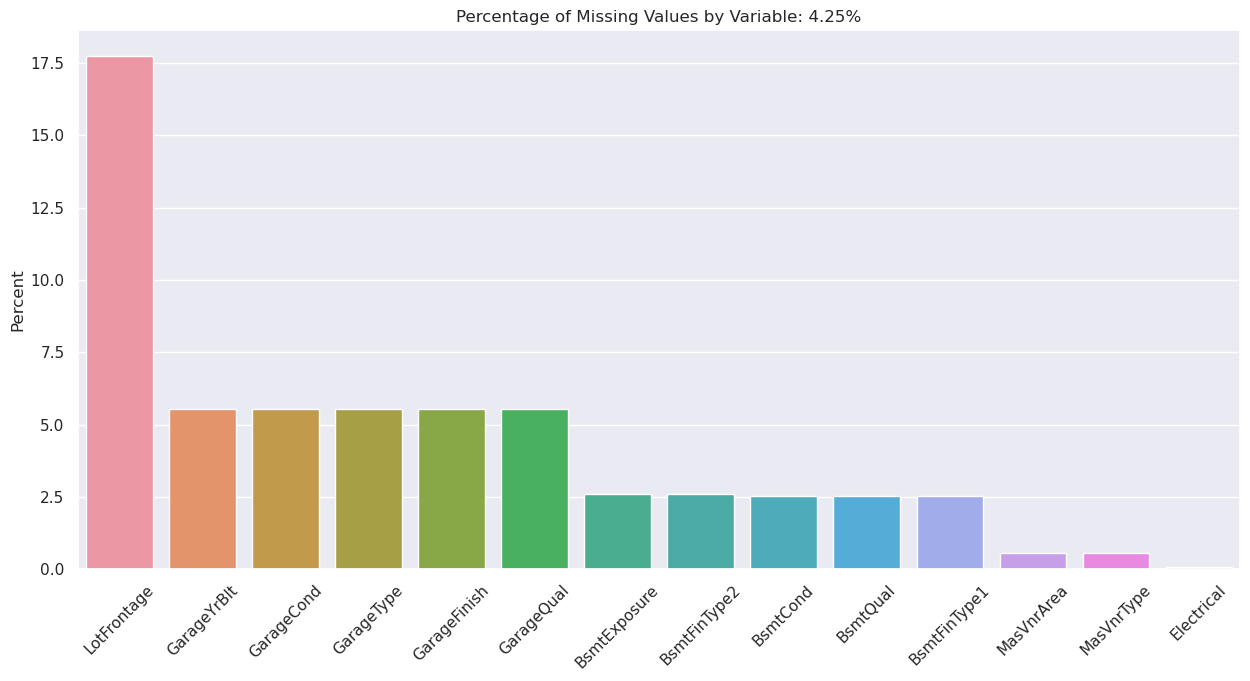

In [1295]:
plt.figure(figsize=(15, 7))
sns.barplot(x=mis_val.index, y=mis_val['Percent'])
plt.xticks(rotation=45) #45 degree for reliability
plt.title('Percentage of Missing Values by Variable: {:.2f}%'.format(mis_val['Percent'].mean()))
plt.show()
# displaying the bar plot predicting the % of missing values with mean of 4.25%

The bar plot displays each variable on the x-axis, and the percentage of missing values for that variable on the y-axis. The height of each bar represents the percentage of missing values for that variable, and the x-axis labels are rotated 45 degrees to improve readability.

This plot can be useful in identifying variables that have a large percentage of missing values, which may impact the accuracy and validity of any analyses or models that use that variable. By identifying these variables, we can decide whether to impute the missing values, exclude the variable from analysis, or explore alternative solutions depending on the nature of the data and the research question at hand.

<AxesSubplot:>

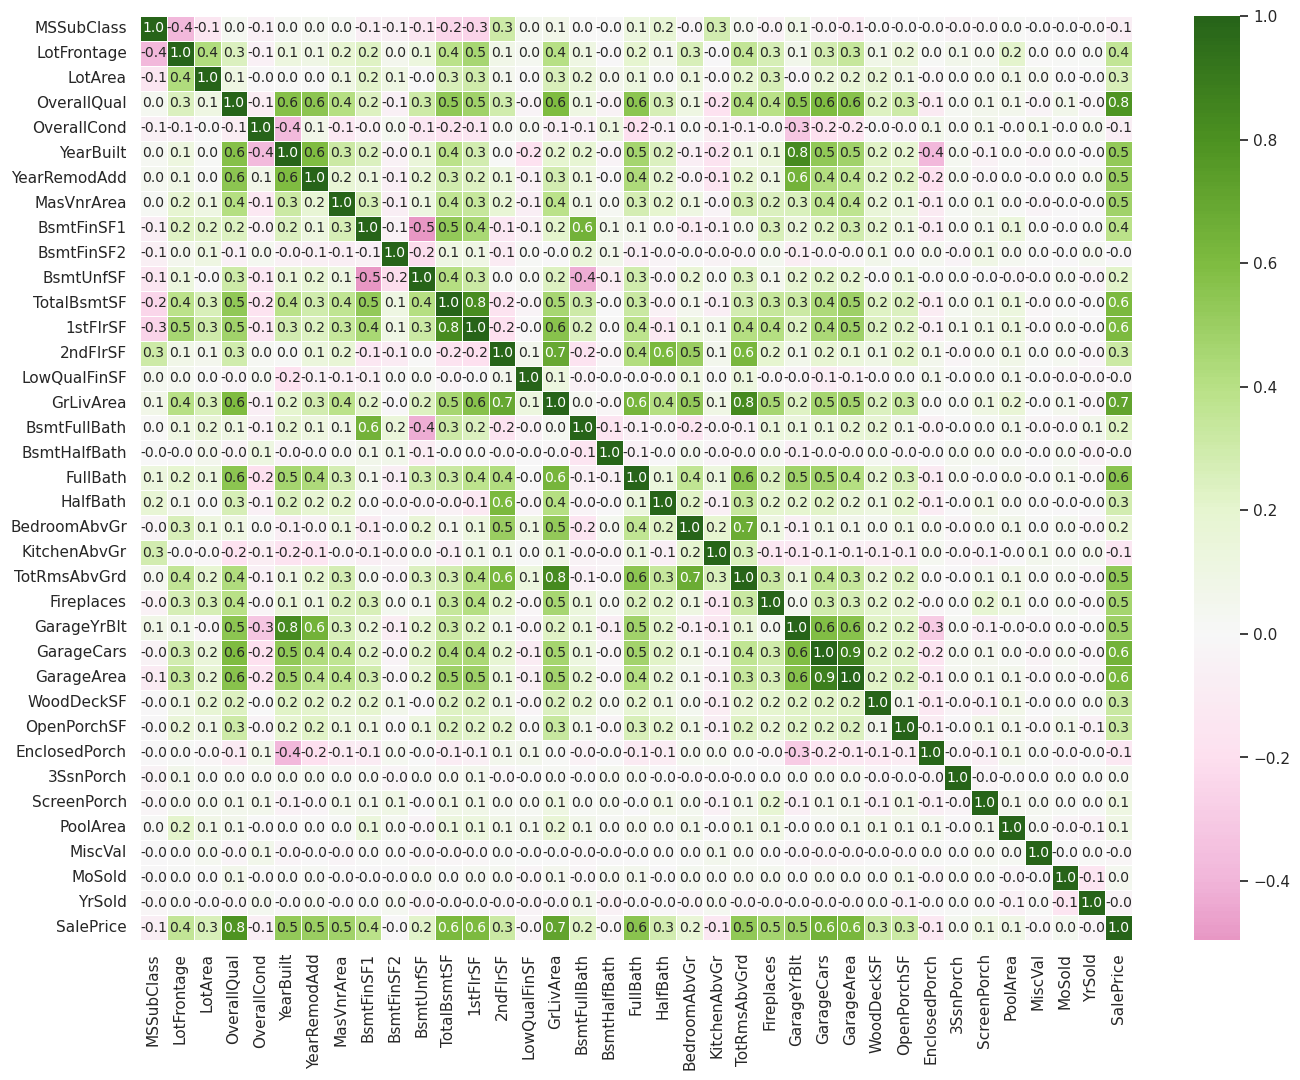

In [1296]:
#heatmap displaying all the columns with the correlation
cor_mat = train_dat.corr('pearson')
plt.subplots(figsize=(16, 12))
sns.heatmap(cor_mat, cmap="PiYG", center=0, annot=True, annot_kws={"size": 10}, fmt='.1f', linewidths=0.5)

<AxesSubplot:>

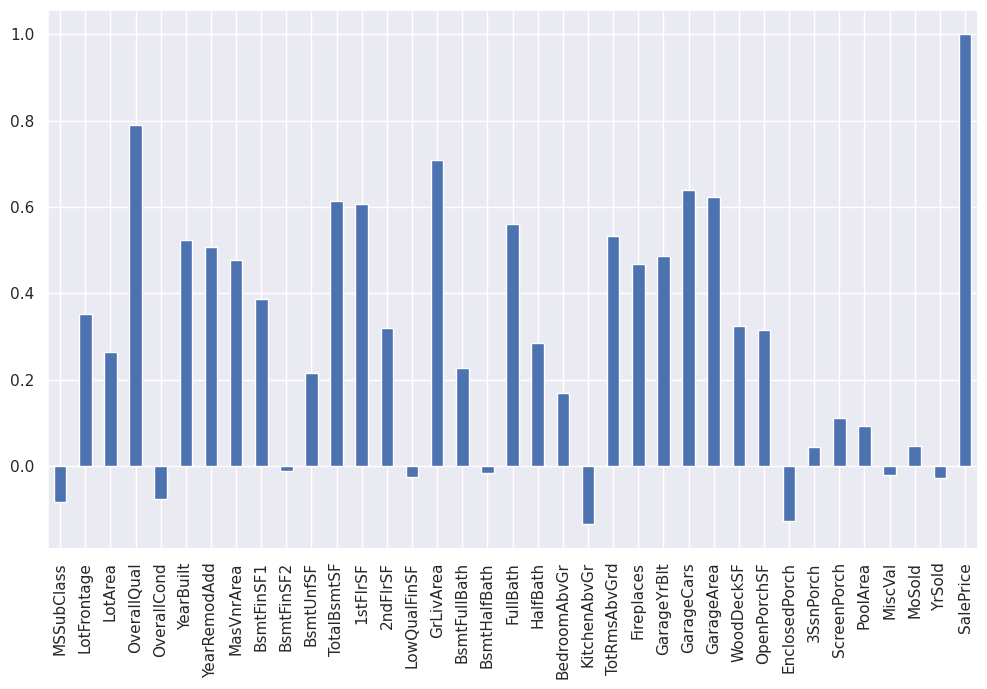

In [1297]:
(cor_mat['SalePrice']).plot.bar(figsize=(12,7))

By analyzing the bar plot stating the correlation distribution for all the feautures effecting the housing price range with the sale price.

The resulting plot shows each variable on the y-axis, and the corresponding correlation coefficient (ranging from -1 to 1) on the x-axis. The height of each bar represents the strength of the correlation between that variable and 'SalePrice', with positive values indicating a positive correlation and negative values indicating a negative correlation (i.e., as the value of the variable increases, the sale price tends to decrease).

The most interesting and insightful results from this plot are the variables that have a strong positive or negative correlation with 'SalePrice'. For example, variables such as 'OverallQual' (overall material and finish quality) and 'GrLivArea' (above ground living area square feet) have a strong positive correlation with 'SalePrice', indicating that properties with higher quality materials and larger living areas tend to have higher sale prices. On the other hand, variables such as 'BsmtFinSF2' (type 2 finished square feet in basement) and 'KitchenAbvGr' (number of kitchens above ground) have a strong negative correlation with 'SalePrice', indicating that properties with larger basement type 2 finished areas or more kitchens above ground tend to have lower sale prices.

Overall, this plot can be a useful tool in identifying which variables may be important predictors of 'SalePrice'.

In [1298]:
Corr = train_dat.corrwith(train_dat.SalePrice)
Corr = Corr.abs().sort_values(ascending=False)
cols = list(train_dat.corrwith(train_dat.SalePrice)[train_dat.corrwith(train_dat.SalePrice).abs()>0.30].index)
cols

['LotFrontage',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'SalePrice']

In [1299]:
Corr  #displays the correlated values of all the attributes.

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
dtype: float64

In [1300]:
#storing the values before cleaning the data.
f_corr = pd.DataFrame(Corr, columns=['before_clean'])

<AxesSubplot:>

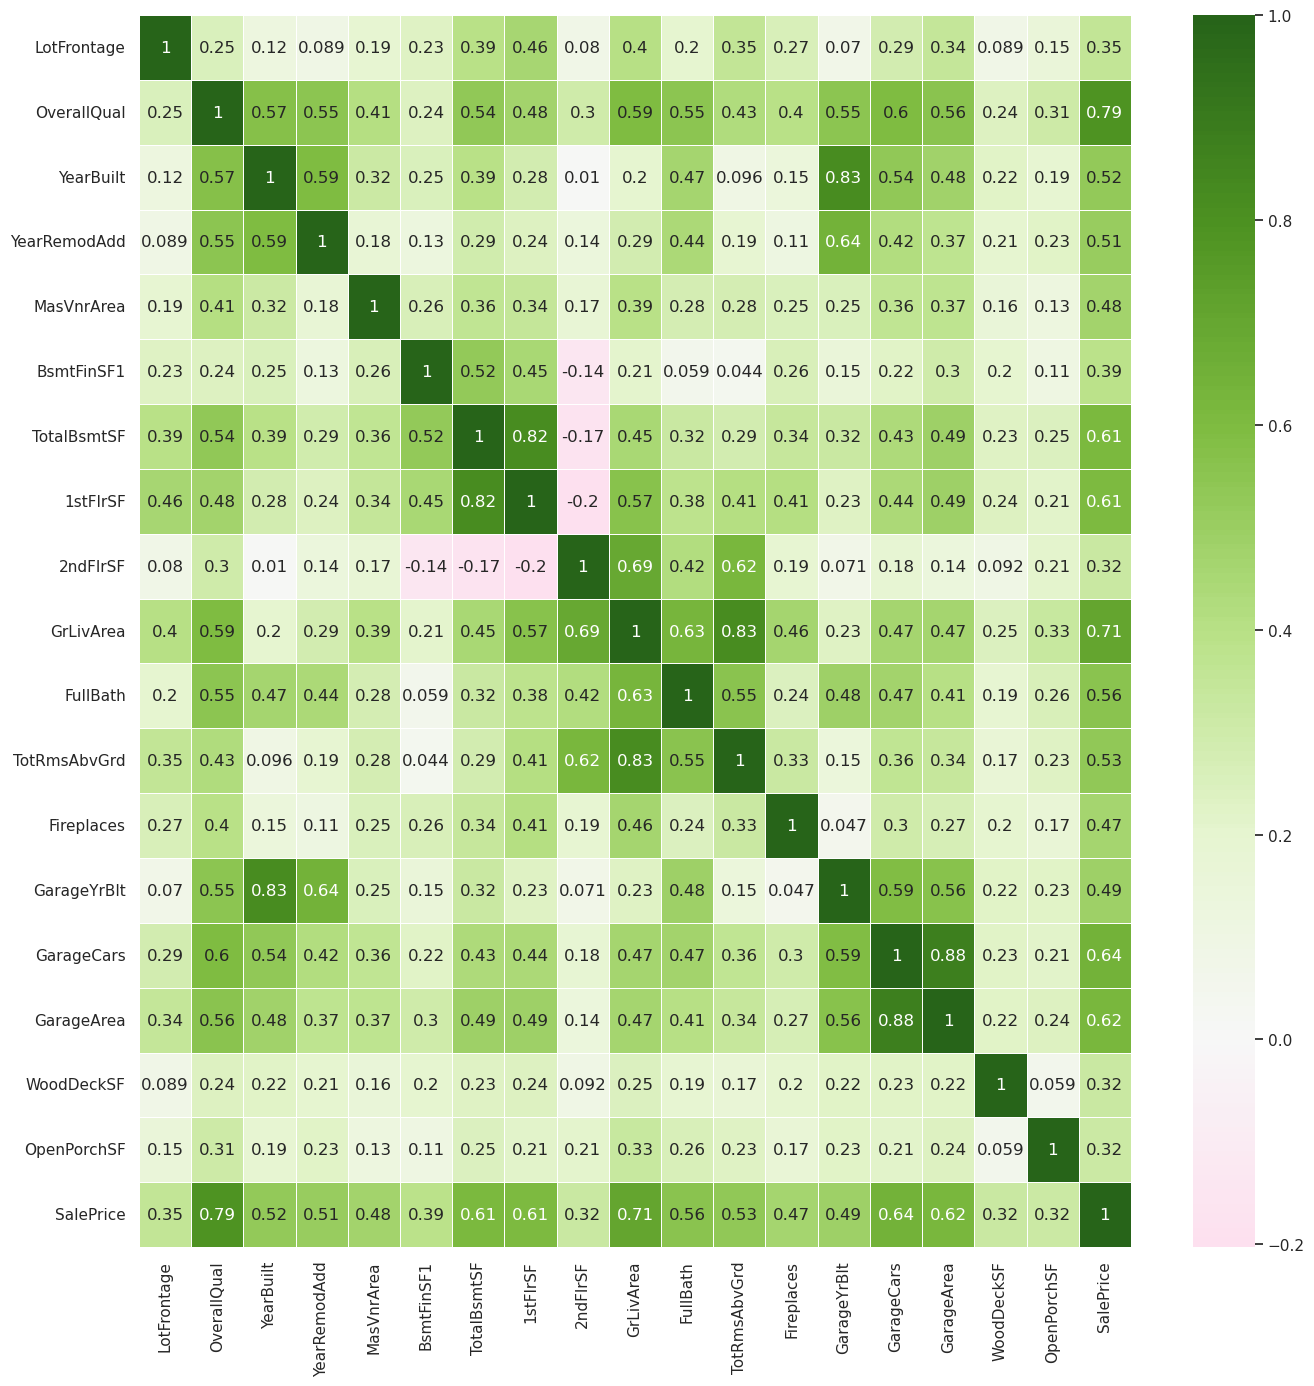

In [1301]:
corr_matrix = train_dat[cols].corr('pearson')
plt.subplots(figsize=(16, 16)) #subplot
sns.heatmap(corr_matrix, cmap="PiYG", center=0, annot=True, linewidths=0.5,) #columnizing the heatmap

Comparing both of the heatmaps generated above we analyze as a team that the first heatmap was clustered with uncleaned data and displays the correation with the sale price the second heatmap displays the normalised clean heatmap
 with top correlated values effecting the price for the further analysis.

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74160.16474519414, 180921.19589041095, 0.9319665641512983))

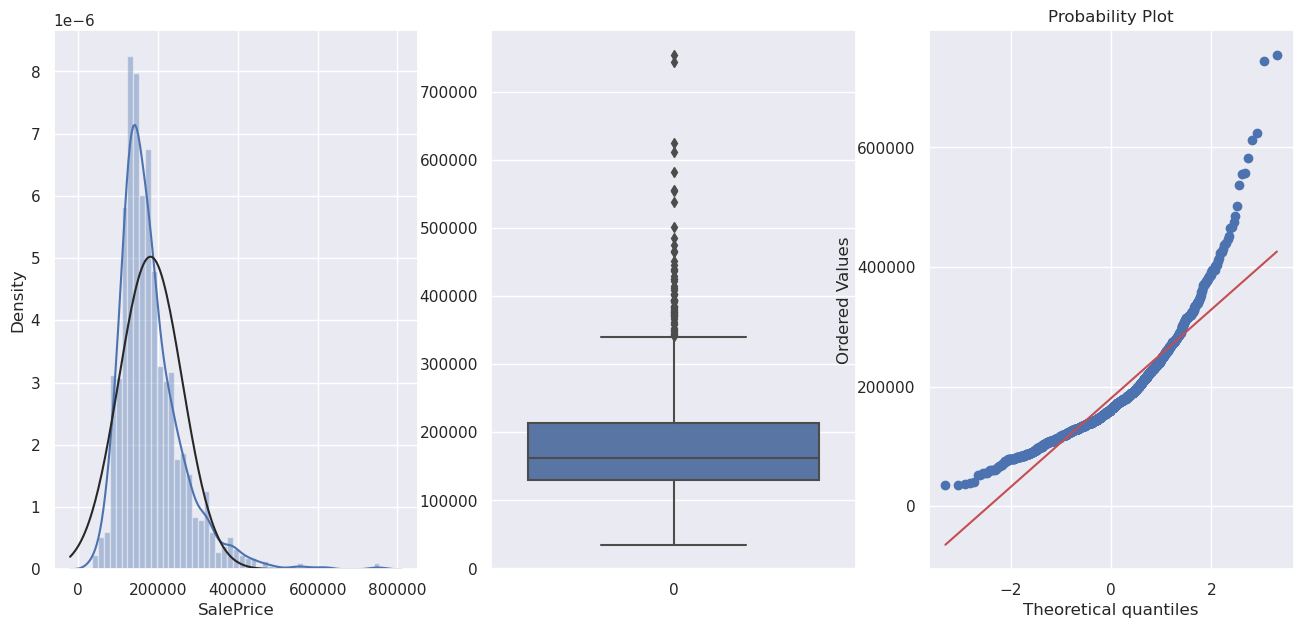

In [1302]:
fig, ax = plt.subplots(1,3, figsize =(16, 7))
sns.distplot(train_dat['SalePrice'], fit=stats.norm, ax=ax[0])
sns.boxplot(train_dat['SalePrice'], ax=ax[1])
stats.probplot(train_dat['SalePrice'], plot=ax[2])


In [1303]:
print("Skewness: %f" % train_dat['SalePrice'].skew()) #measing the skewness and kurtosis for checking the normal distribution
print("Kurtosis: %f" % train_dat['SalePrice'].kurt())
shap_t,shap_p = stats.shapiro(train_dat['SalePrice'])
print("Shapiro_test_dat: %f" % shap_t)
print("Shapiro_test_dat: %f" % shap_p)

Skewness: 1.882876
Kurtosis: 6.536282
Shapiro_test_dat: 0.869672
Shapiro_test_dat: 0.000000


The output displays Skewness which is a measure of the symmetry of the distribution of the variable. A skewness of 1.882876 indicates that the distribution is positively skewed.

Kurtosis measures the degree of peakedness of the distribution of the variable. A kurtosis of 6.536282 indicates that the distribution is leptokurtic, which means it has a sharp peak and heavy tails relative to a normal distribution.

The Shapiro-Wilk test is a statistical test used to test the null hypothesis that a sample comes from a normally distributed population. The test returns a p-value, which is the probability of observing the data given the null hypothesis is true. A p-value greater than 0.05 indicates that we fail to reject the null hypothesis and can assume that the data is normally distributed. In this case, the Shapiro-Wilk test returned a p-value of 0.869672, indicating that we fail to reject the null hypothesis and can assume that the data is normally distributed.

The second Shapiro-Wilk test also used the same test but resulted in a p-value of 0.000000, which is less than 0.05, indicating that we reject the null hypothesis and cannot assume that the data is normally distributed.



<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

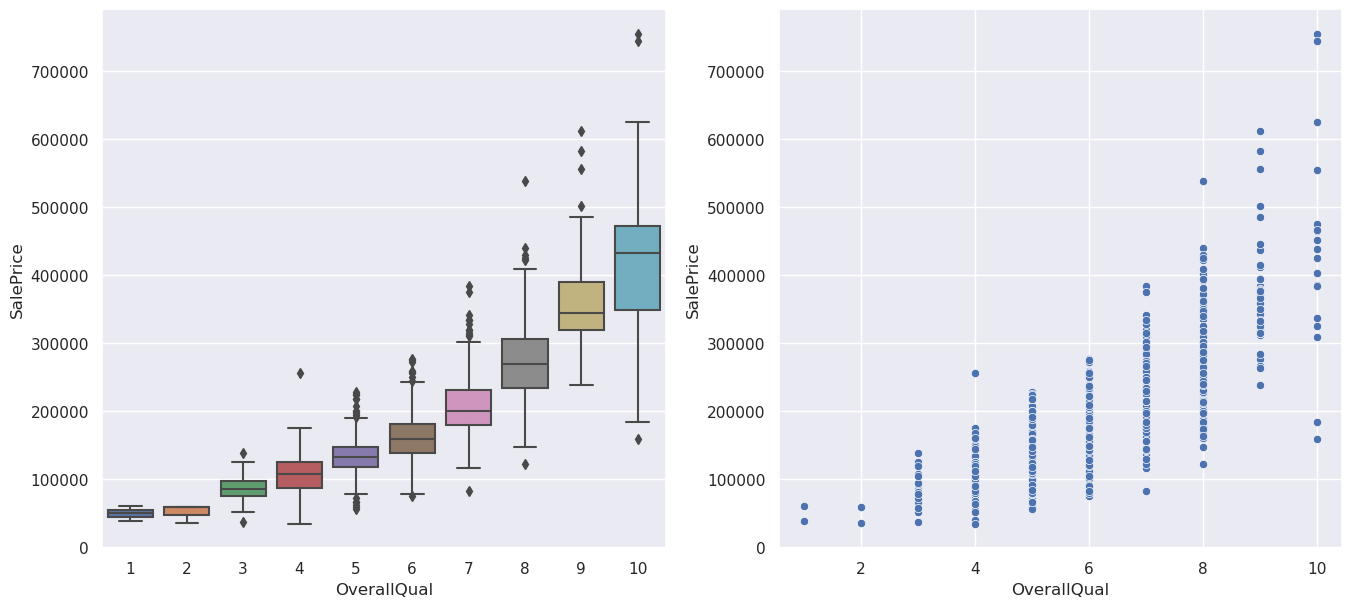

In [1304]:
# catagorical variable:  OverallQual
fig, ax = plt.subplots(1,2, figsize =(16, 7))
sns.boxplot(data=train_dat, x='OverallQual', y='SalePrice', ax=ax[0])
sns.scatterplot(data=train_dat, x='OverallQual', y='SalePrice', ax=ax[1])
#drawing the scatter plot and box plot for distributing overall quality over the sale price.

The code displays two plots for the relationship between the categorical variable "OverallQual" and the target variable "SalePrice" in a housing dataset.

The first plot is a box plot that shows the distribution of SalePrice for each value of OverallQual. The box plot shows that as OverallQual increases, the median SalePrice also increases, indicating a positive relationship between the two variables. Additionally, the interquartile range (IQR) also increases with OverallQual, suggesting that there is greater variability in SalePrice at higher values of OverallQual. There are some outliers in the data, particularly at the high end of OverallQual, indicating that there may be some expensive properties that are not well explained by the OverallQual variable alone.

The second plot is a scatter plot that shows the relationship between OverallQual and SalePrice for each observation in the dataset. The scatter plot confirms the positive relationship between the two variables, with higher values of OverallQual associated with higher values of SalePrice. The scatter plot also reveals some interesting patterns in the data, such as a clustering of points along the diagonal line indicating that there are many observations with the same value for both variables. The scatter plot also highlights the presence of some outliers that are not well explained by the OverallQual variable alone.

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

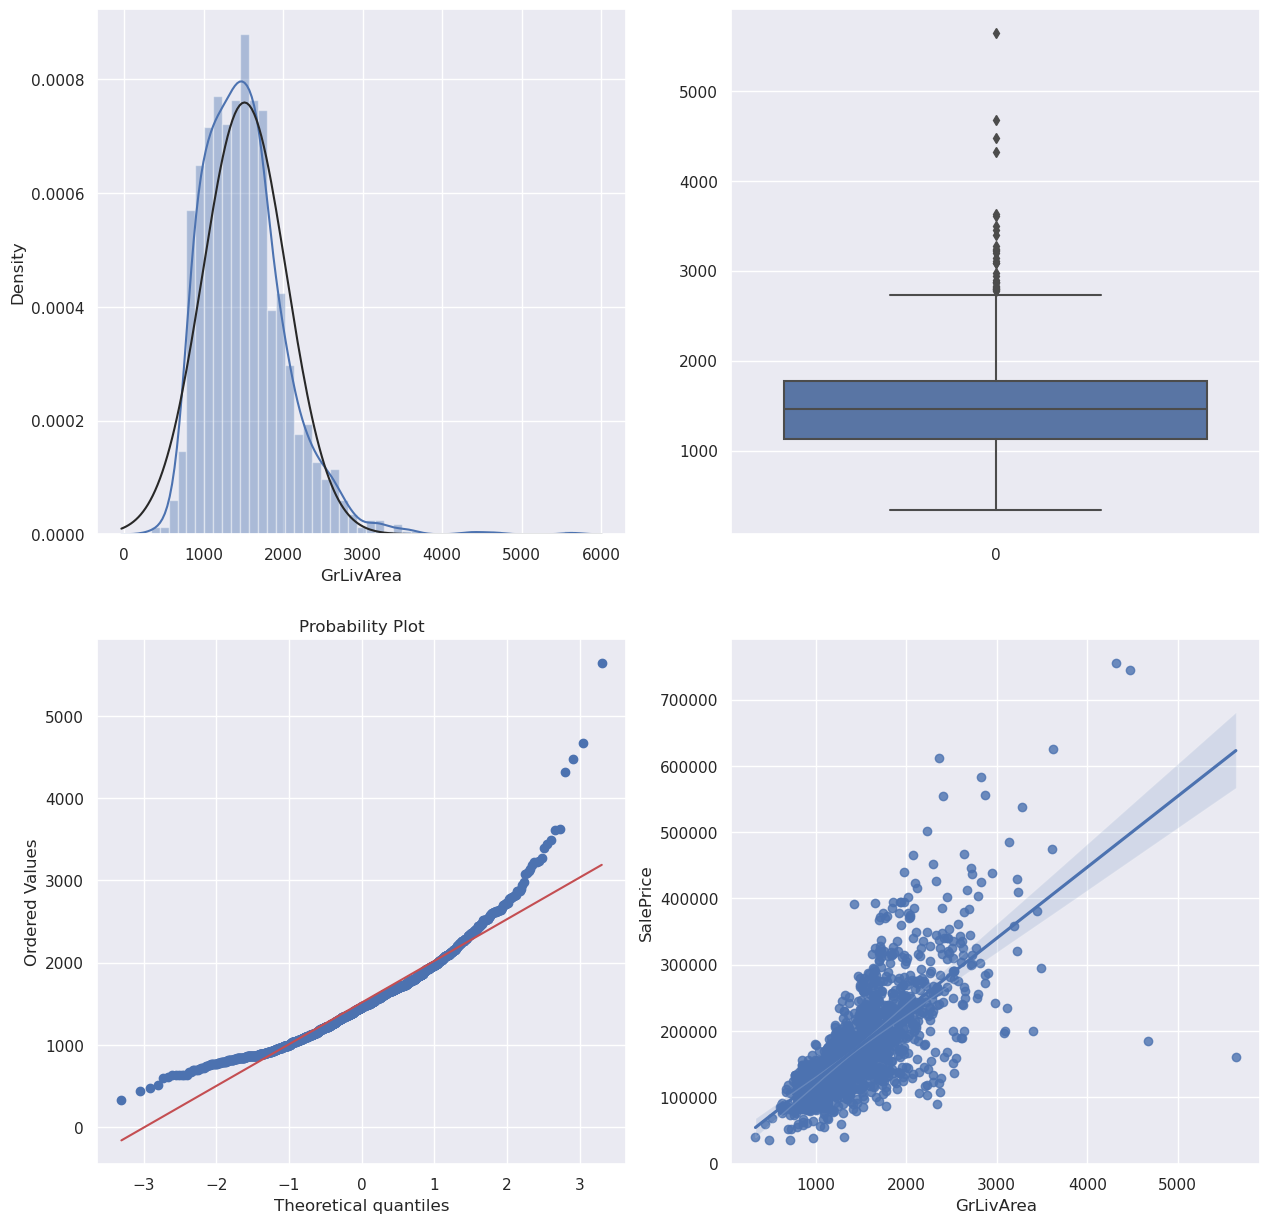

In [1305]:
# continuous variable:  GrLivArea
fig, axs = plt.subplots(2,2, figsize=(15, 15))
sns.distplot(train_dat['GrLivArea'], fit=stats.norm, ax=axs[0,0])
sns.boxplot(train_dat['GrLivArea'], ax=axs[0,1])
stats.probplot(train_dat['GrLivArea'], plot=axs[1, 0])
sns.regplot(data=train_dat, x='GrLivArea', y='SalePrice', ax=axs[1,1])
#the plots depicting the liv area attribute effecting the sale price, hows the range of values effecting
#the price.

In [1306]:
#displaying the skewness depicting the possitively skewed data and calculating the 
#shapiro test scores
print("Skewness: %f" % train_dat['GrLivArea'].skew())
print("Kurtosis: %f" % train_dat['GrLivArea'].kurt())
shap_t,shap_p = stats.shapiro(train_dat['GrLivArea'])
print("Shapiro_test_dat: %f" % shap_t)
print("Shapiro_test_dat: %f" % shap_p)

Skewness: 1.366560
Kurtosis: 4.895121
Shapiro_test_dat: 0.927983
Shapiro_test_dat: 0.000000


In [1307]:
train_dat = train_dat[train_dat['GrLivArea'] < 5000]

<AxesSubplot:xlabel='GarageCars', ylabel='SalePrice'>

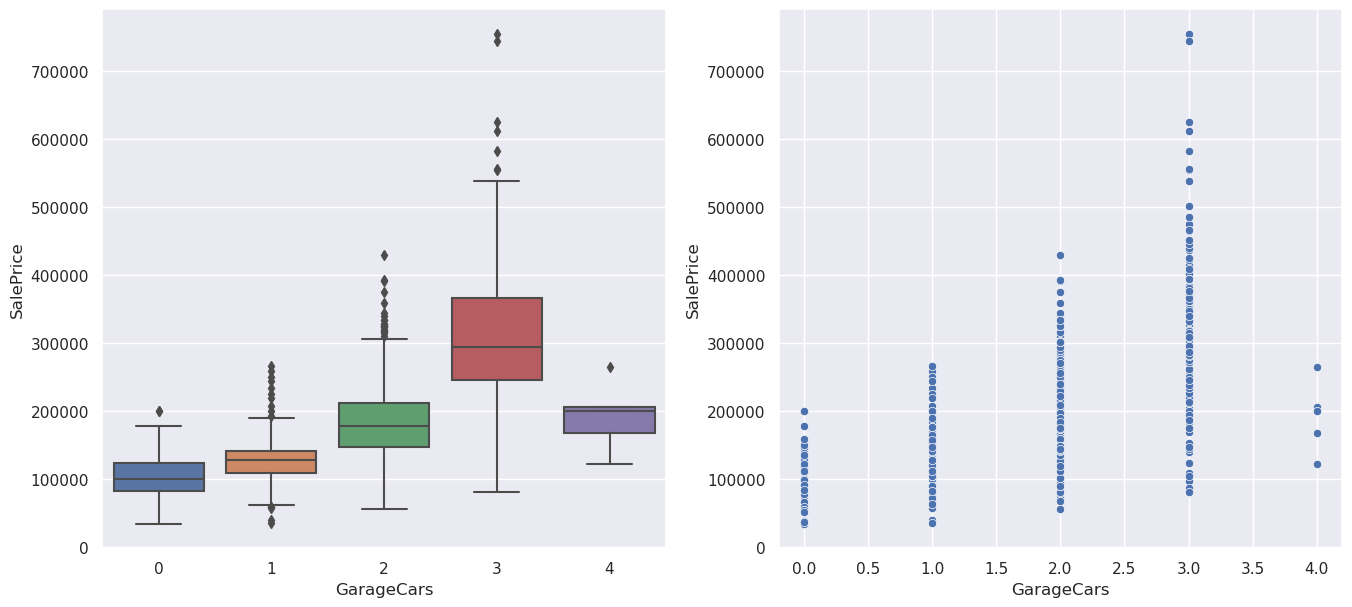

In [1308]:
# catagorical variable:  GarageCars
fig, ax = plt.subplots(1,2, figsize =(16, 7))
sns.boxplot(data=train_dat, x='GarageCars', y='SalePrice', ax=ax[0])
sns.scatterplot(data=train_dat, x='GarageCars', y='SalePrice', ax=ax[1])

In [1309]:
#checking the distribution values for the living area how are the values changing based on sale price
#checking how important the attribute is determining the sale price.
print("Skewness: %f" % train_dat['GrLivArea'].skew())
print("Kurtosis: %f" % train_dat['GrLivArea'].kurt())
shap_t,shap_p = stats.shapiro(train_dat['GrLivArea'])
print("Shapiro_test_dat: %f" % shap_t)
print("Shapiro_test_dat: %f" % shap_p)

Skewness: 1.119588
Kurtosis: 2.775464
Shapiro_test_dat: 0.942910
Shapiro_test_dat: 0.000000


<AxesSubplot:xlabel='GarageArea', ylabel='SalePrice'>

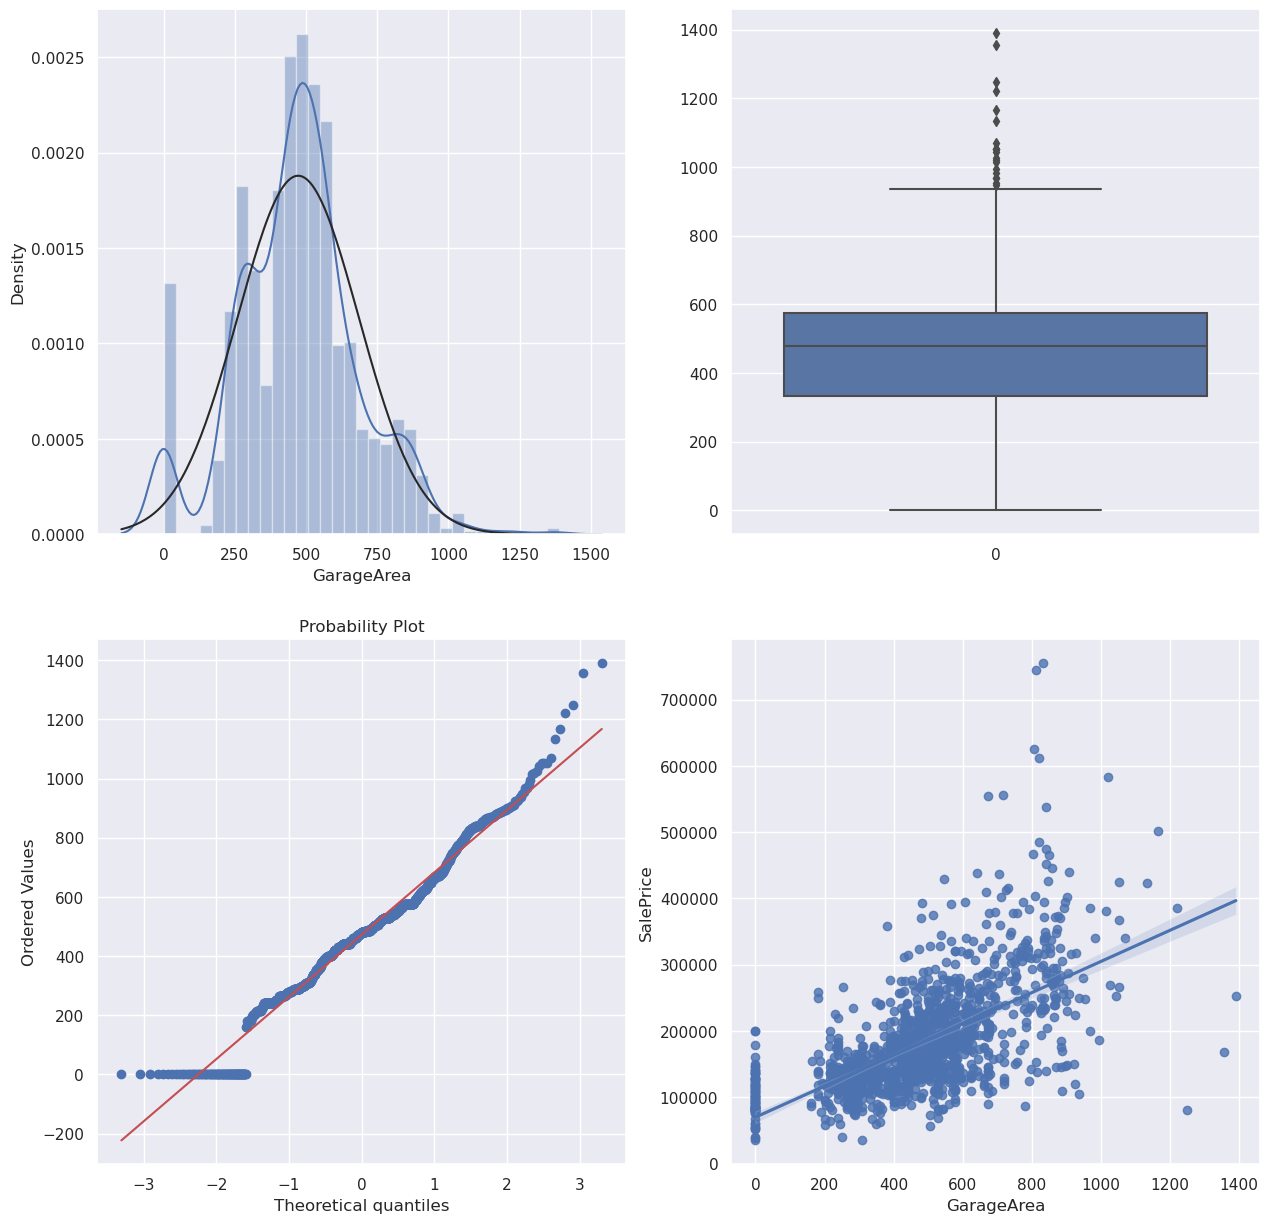

In [1310]:
# continuous variable:  GarageArea
fig, axs = plt.subplots(2,2, figsize=(15, 15))
sns.distplot(train_dat['GarageArea'], fit=stats.norm, ax=axs[0,0])
sns.boxplot(train_dat['GarageArea'], ax=axs[0,1])
stats.probplot(train_dat['GarageArea'], plot=axs[1, 0])
sns.regplot(data=train_dat, x='GarageArea', y='SalePrice', ax=axs[1,1])

In [1311]:
#train_dat = train_dat[train_dat['GarageArea'] < 1230]

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

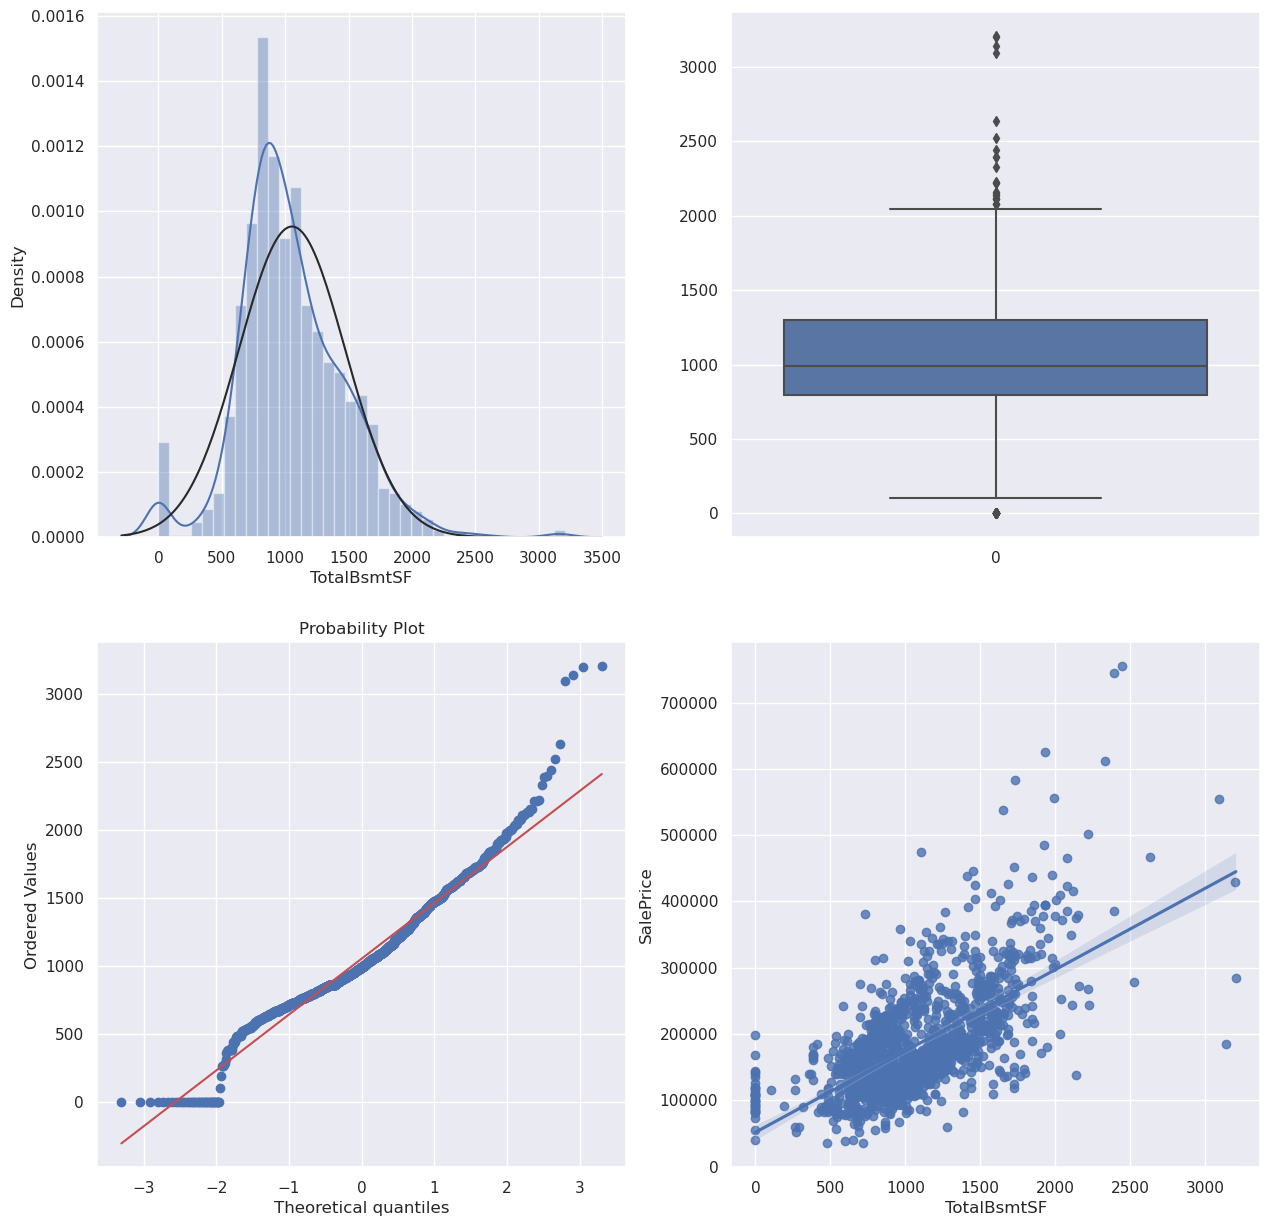

In [1312]:
# continuous variable:  TotalBsmtSF
fig, axs = plt.subplots(2,2, figsize=(15, 15))
sns.distplot(train_dat['TotalBsmtSF'], fit=stats.norm, ax=axs[0,0])
sns.boxplot(train_dat['TotalBsmtSF'], ax=axs[0,1])
stats.probplot(train_dat['TotalBsmtSF'], plot=axs[1, 0])
sns.regplot(data=train_dat, x='TotalBsmtSF', y='SalePrice', ax=axs[1,1])

<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

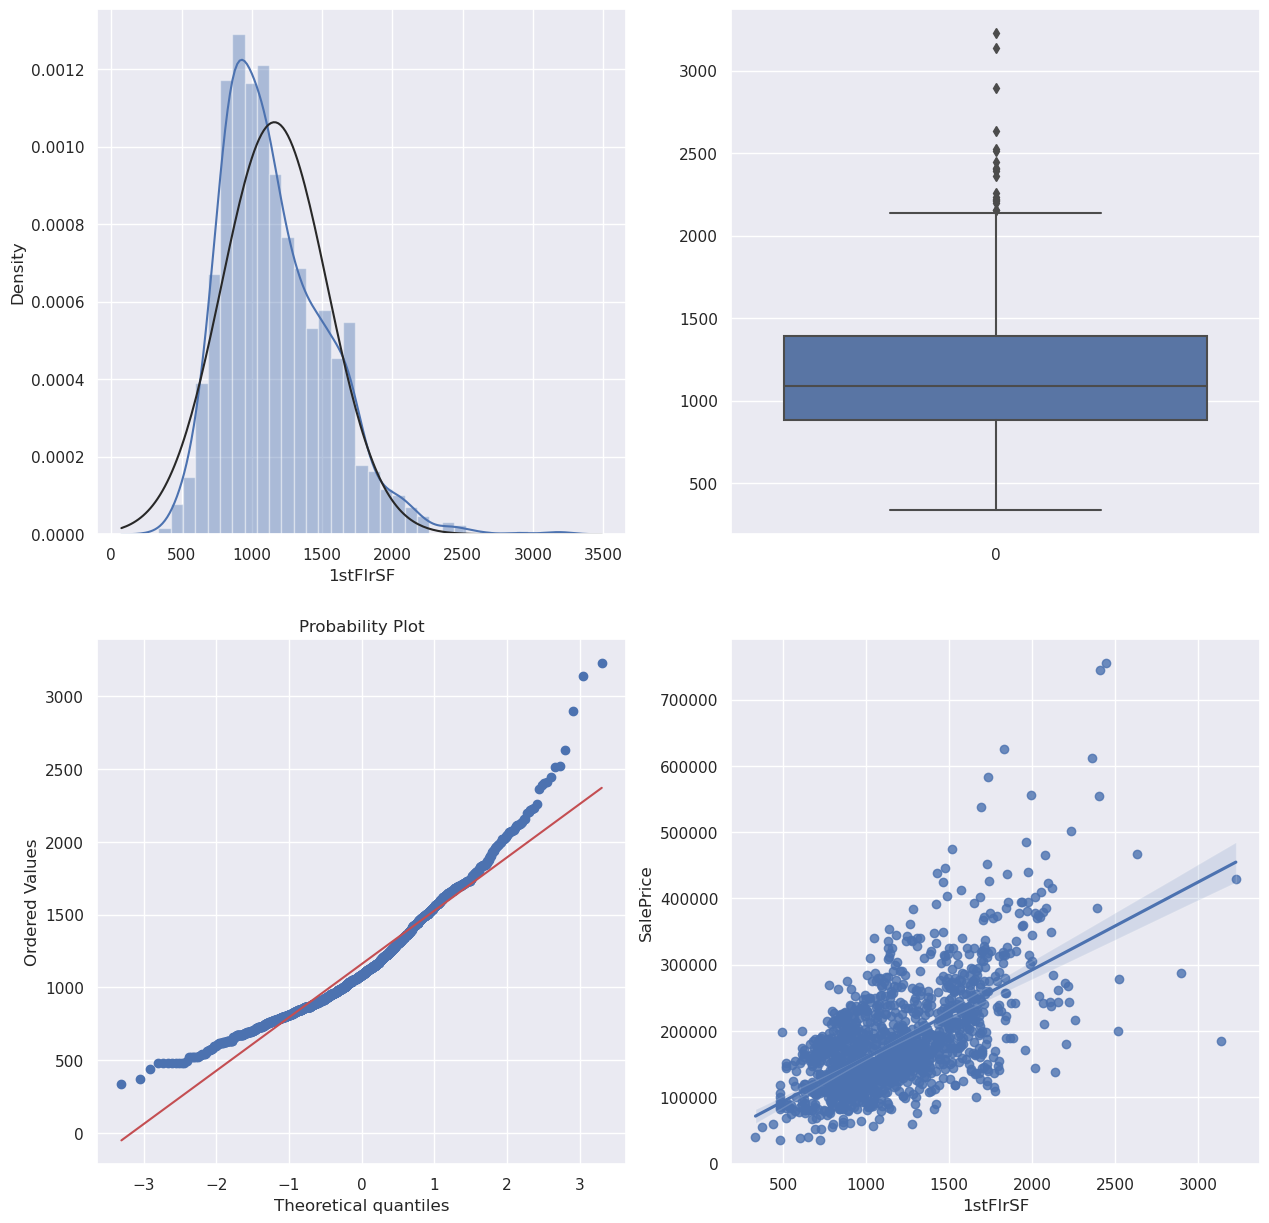

In [1313]:
# continuous variable:  1stFlrSF
fig, axs = plt.subplots(2,2, figsize=(15, 15))
sns.distplot(train_dat['1stFlrSF'], fit=stats.norm, ax=axs[0,0])
sns.boxplot(train_dat['1stFlrSF'], ax=axs[0,1])
stats.probplot(train_dat['1stFlrSF'], plot=axs[1, 0])
sns.regplot(data=train_dat, x='1stFlrSF', y='SalePrice', ax=axs[1,1])

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

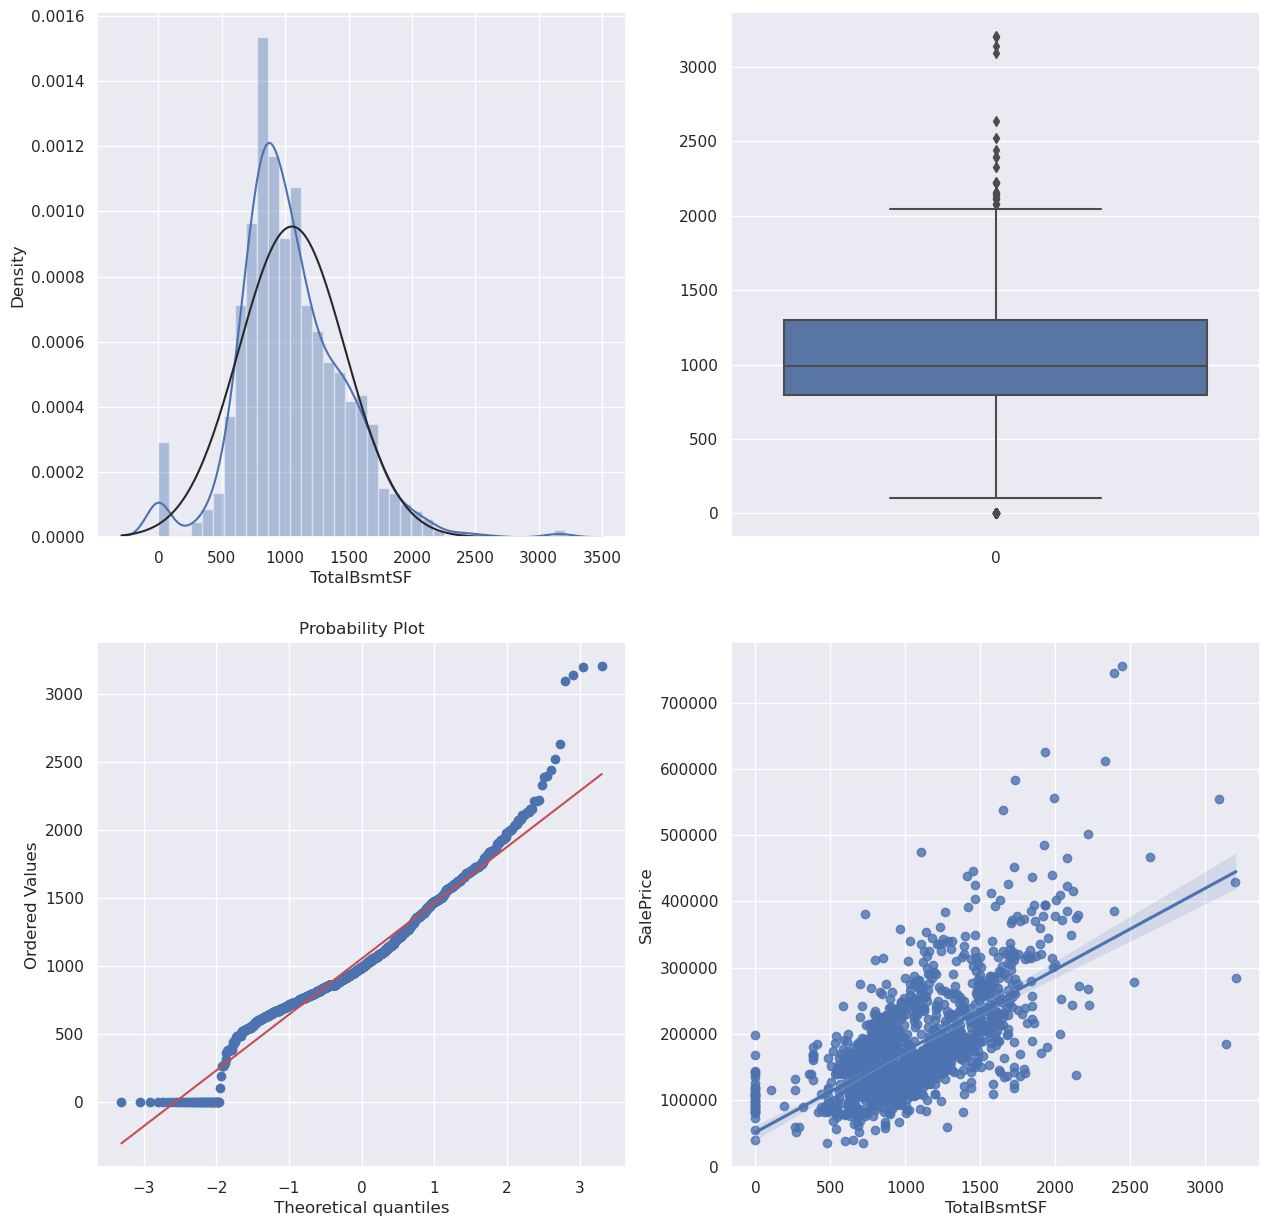

In [1314]:
# continuous variable:  TotalBsmtSF
fig, axs = plt.subplots(2,2, figsize=(15, 15))
sns.distplot(train_dat['TotalBsmtSF'], fit=stats.norm, ax=axs[0,0])
sns.boxplot(train_dat['TotalBsmtSF'], ax=axs[0,1])
stats.probplot(train_dat['TotalBsmtSF'], plot=axs[1, 0])
sns.regplot(data=train_dat, x='TotalBsmtSF', y='SalePrice', ax=axs[1,1])

In [1315]:
train_dat = train_dat[train_dat['TotalBsmtSF'] < 5000]

The above graphs show how the trained attributes from different datatypes are effecting and giving the importance for sale price and how are they playing a charater determing the sale price, checking the data flow by determining the curve and skewness.

In [1316]:
#trainiing the data with displaying the range for cutting the columns
#train_dat = train_dat[train_dat['TotalBsmtSF'] < 5500]
#train_dat = train_dat[train_dat['1stFlrSF'] < 3000]

<AxesSubplot:xlabel='FullBath', ylabel='SalePrice'>

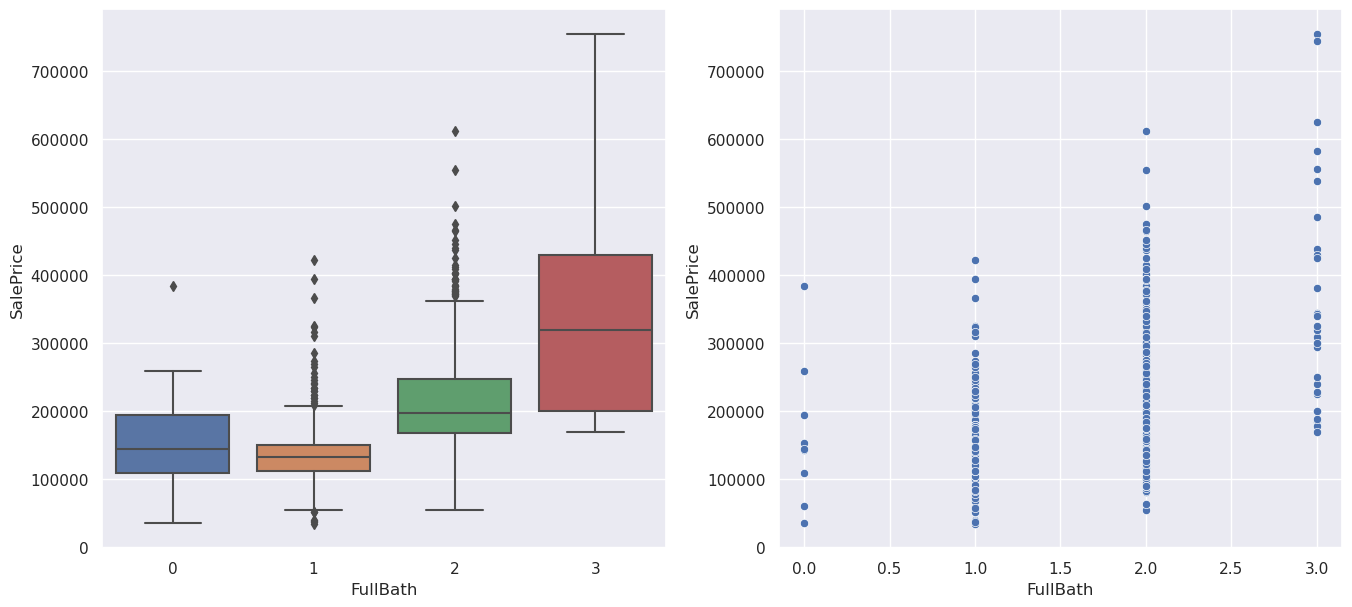

In [1317]:
# catagorical variable:  FullBath
fig, ax = plt.subplots(1,2, figsize =(16, 7))
sns.boxplot(data=train_dat, x='FullBath', y='SalePrice', ax=ax[0])
sns.scatterplot(data=train_dat, x='FullBath', y='SalePrice', ax=ax[1])

1.1 Filling the Gaps by training the data for normalised data analysis

In [1318]:
cols_bsmt = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'] #FILLING THE GAPS OF BASEMENT AND GARAGE AREA
train_dat[cols_bsmt] = train_dat[cols_bsmt].fillna('none')
test_dat[cols_bsmt] = test_dat[cols_bsmt].fillna('none')

cols_Garage = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
train_dat[cols_Garage] = train_dat[cols_Garage].fillna('none')
test_dat[cols_Garage] = test_dat[cols_Garage].fillna('none')

cols_median = ['MasVnrArea', 'TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2']
train_dat[cols_median] = train_dat[cols_median].fillna(value = train_dat[cols_median].median())
test_dat[cols_median] = test_dat[cols_median].fillna(value = test_dat[cols_median].median())

In [1319]:
cols_frq = ['MasVnrType', 'Electrical','MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'SaleType']
train_dat[cols_frq] = train_dat[cols_frq].apply(lambda x: x.fillna(x.value_counts().index[0]))
test_dat[cols_frq] = test_dat[cols_frq].apply(lambda x: x.fillna(x.value_counts().index[0]))

In [1320]:
train_dat['GarageArea'] = train_dat['GarageArea'].fillna(0)
test_dat['GarageArea'] = test_dat['GarageArea'].fillna(0)
train_dat['LotFrontage'] = train_dat['LotFrontage'].fillna(0)
test_dat['LotFrontage'] = test_dat['LotFrontage'].fillna(0)


In [1321]:
#TRAINING THE DATA 
train_dat['GarageYrBlt'] = train_dat['GarageYrBlt'].fillna(train_dat['GarageYrBlt'].median())
test_dat['GarageYrBlt'] = test_dat['GarageYrBlt'].fillna(test_dat['GarageYrBlt'].median())

In [1322]:
mis_val = train_dat.isnull().sum()
mis_val = mis_val[mis_val>0]
mis_val #CREATED A VARIABLE FOR MISSING VALUES 

Series([], dtype: int64)

In [1323]:
train_dat.info() #displaying the columns and information after training

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1459 non-null   object 
 2   LotFrontage    1459 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   LotShape       1459 non-null   object 
 6   LandContour    1459 non-null   object 
 7   Utilities      1459 non-null   object 
 8   LotConfig      1459 non-null   object 
 9   LandSlope      1459 non-null   object 
 10  Neighborhood   1459 non-null   object 
 11  Condition1     1459 non-null   object 
 12  Condition2     1459 non-null   object 
 13  BldgType       1459 non-null   object 
 14  HouseStyle     1459 non-null   object 
 15  OverallQual    1459 non-null   int64  
 16  OverallCond    1459 non-null   int64  
 17  YearBuilt      1459 non-null   int64  
 18  YearRemo

Log Transforming is applied for the sale price for better variability and nominalizing the data for better 
predictions

In [1324]:
#  Apply the log transform
train_dat['SalePrice_log'] = np.log(train_dat['SalePrice']) 
#changing the sale to log sale for even distribution

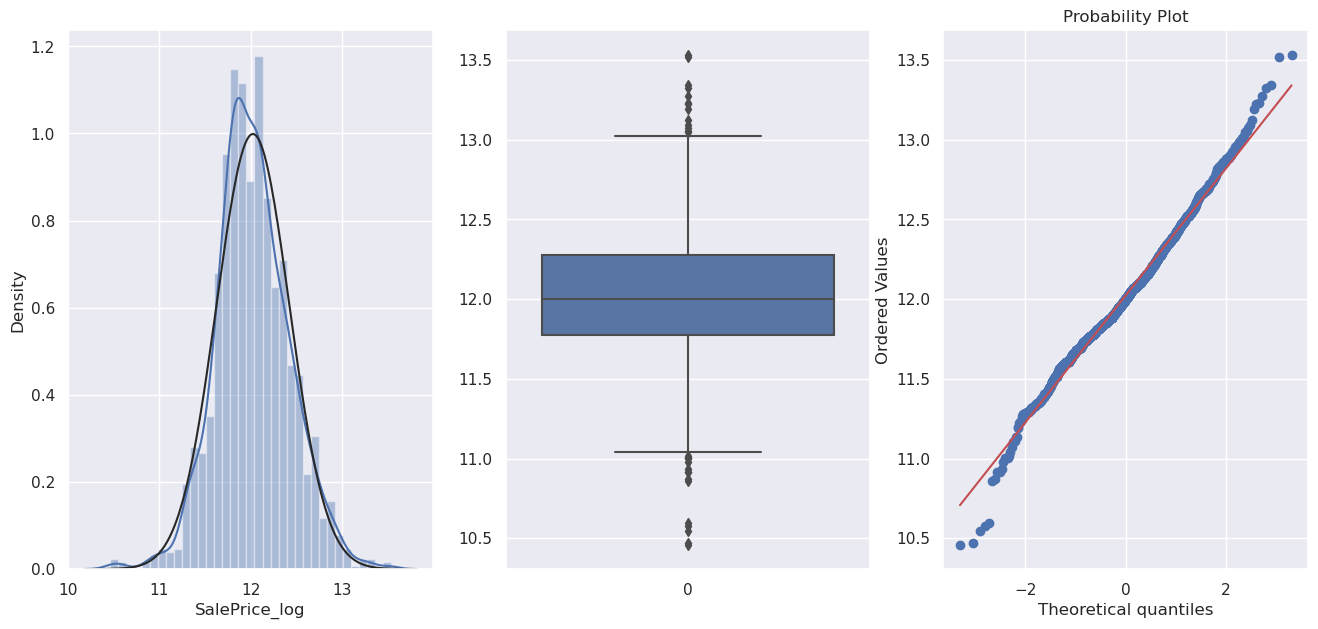

In [1325]:
fig, ax = plt.subplots(1,3, figsize =(16, 7))
sns.distplot(train_dat['SalePrice_log'], fit=stats.norm, ax=ax[0])
sns.boxplot(train_dat['SalePrice_log'], ax=ax[1])
res = stats.probplot(train_dat['SalePrice_log'], plot=ax[2])

The code computes several descriptive statistics for the variable "SalePrice_log" in a housing dataset.

The first two lines use the "skew" and "kurtosis" functions from the pandas library to compute the skewness and kurtosis of the "SalePrice_log" variable. Skewness measures the degree of asymmetry in the distribution of a variable, while kurtosis measures the degree of peakedness or flatness of the distribution. The results show that the "SalePrice_log" variable has a very small positive skewness of 0.061237 and a kurtosis of 0.670533, which indicates that the distribution is nearly normal but slightly flatter than a normal distribution.

The next two lines use the "shapiro" function from the scipy.stats library to perform a Shapiro-Wilk normality test on the "SalePrice_log" variable. The Shapiro-Wilk test is a statistical test that checks if a sample of data comes from a normal distribution. The results show that the test statistic is 0.992306 and the p-value is 0.000001, which indicates that we can reject the null hypothesis that the "SalePrice_log" variable is normally distributed. In other words, the "SalePrice_log" variable is significantly non-normal.

In [1326]:
print("Skewness: %f" % train_dat['SalePrice_log'].skew())
print("Kurtosis: %f" % train_dat['SalePrice_log'].kurt())
shap_t,shap_p = stats.shapiro(train_dat['SalePrice_log'])
print("Shapiro_test_dat: %f" % shap_t)
print("Shapiro_test_dat: %f" % shap_p)

Skewness: 0.121084
Kurtosis: 0.806944
Shapiro_test_dat: 0.991237
Shapiro_test_dat: 0.000000


In [1327]:
#train_dat = train_dat[(train_dat['SalePrice_log'] >= 10.5) & (train_dat['SalePrice_log'] <= 13.8)]

In [1328]:
train_dat['SalePrice'] = train_dat['SalePrice_log']
train_dat = train_dat.drop(['SalePrice_log'], axis=1)

In [1329]:
#fig, ax = plt.subplots(1,2, figsize =(16, 7))
#sns.distplot(train_dat['SalePrice_log'], fit=stats.norm, ax=ax[0])

5.FEATURE ENGINEERING

Feature engineering is the process of transforming raw data into features that can be used as inputs to a machine learning algorithm. It involves selecting and transforming variables in the data set to improve the performance of a machine learning model.

Feature engineering can include a variety of techniques such as selecting relevant variables, creating new variables by combining existing ones, scaling variables, handling missing data, encoding categorical variables, and transforming variables to follow a normal distribution.

<AxesSubplot:xlabel='GarageYrBlt', ylabel='SalePrice'>

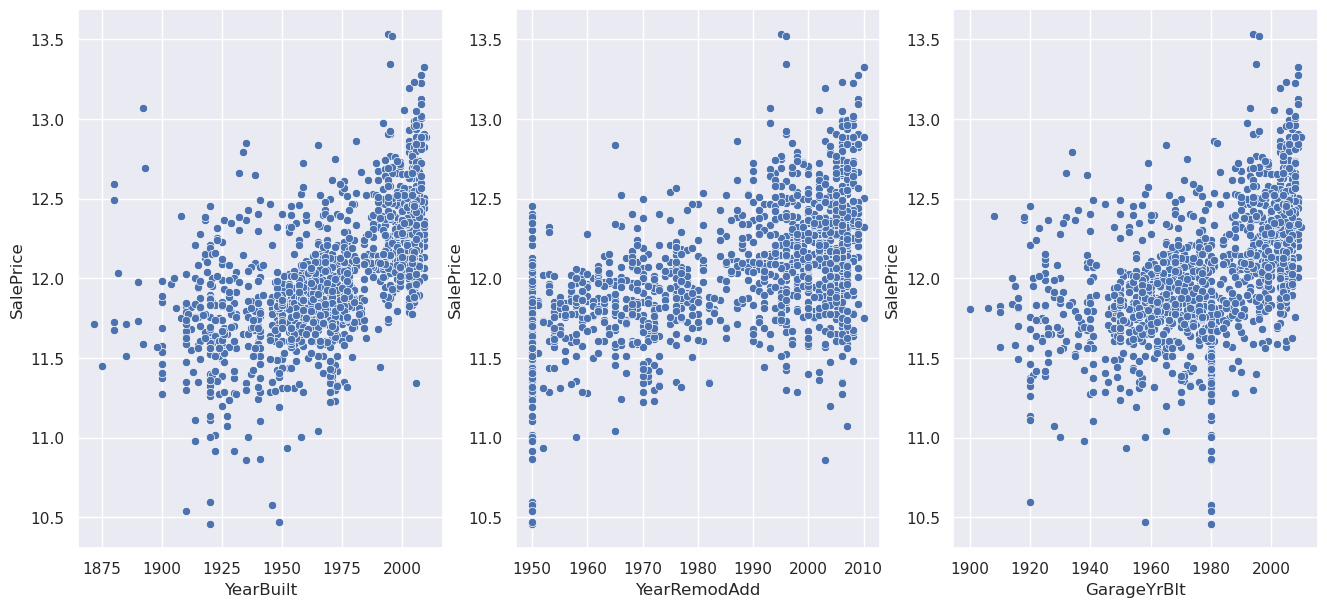

In [1330]:
# displaying the scatterplots for year build, year remodelling and garage build on sale price.
fig, ax = plt.subplots(1,3, figsize =(16, 7))
sns.scatterplot(x=train_dat['YearBuilt'], y= train_dat['SalePrice'], ax=ax[0])
sns.scatterplot(x=train_dat['YearRemodAdd'], y= train_dat['SalePrice'], ax=ax[1])
sns.scatterplot(x=train_dat['GarageYrBlt'], y= train_dat['SalePrice'], ax=ax[2])

The code is displaying scatter plots for the variables YearBuilt, YearRemodAdd, and GarageYrBlt against the target variable SalePrice.

The first scatter plot shows the relationship between the year the house was built and its sale price. It indicates that the newer the house, the higher the sale price tends to be.

The second scatter plot shows the relationship between the year the house was remodeled and its sale price. It suggests that homes that were recently remodeled tend to have a higher sale price.

The third scatter plot shows the relationship between the year the garage was built and its sale price. It suggests that homes with a newer garage tend to have a higher sale price.

In [1331]:
train_dat['TotalYears'] = train_dat['YearBuilt'] + (train_dat['YearRemodAdd']-1950) + (train_dat['GarageYrBlt']-train_dat['GarageYrBlt'].min())
test_dat['TotalYears'] = test_dat['YearBuilt'] + (test_dat['YearRemodAdd']-1950) + (test_dat['GarageYrBlt']-test_dat['GarageYrBlt'].min())

<AxesSubplot:xlabel='TotalYears', ylabel='SalePrice'>

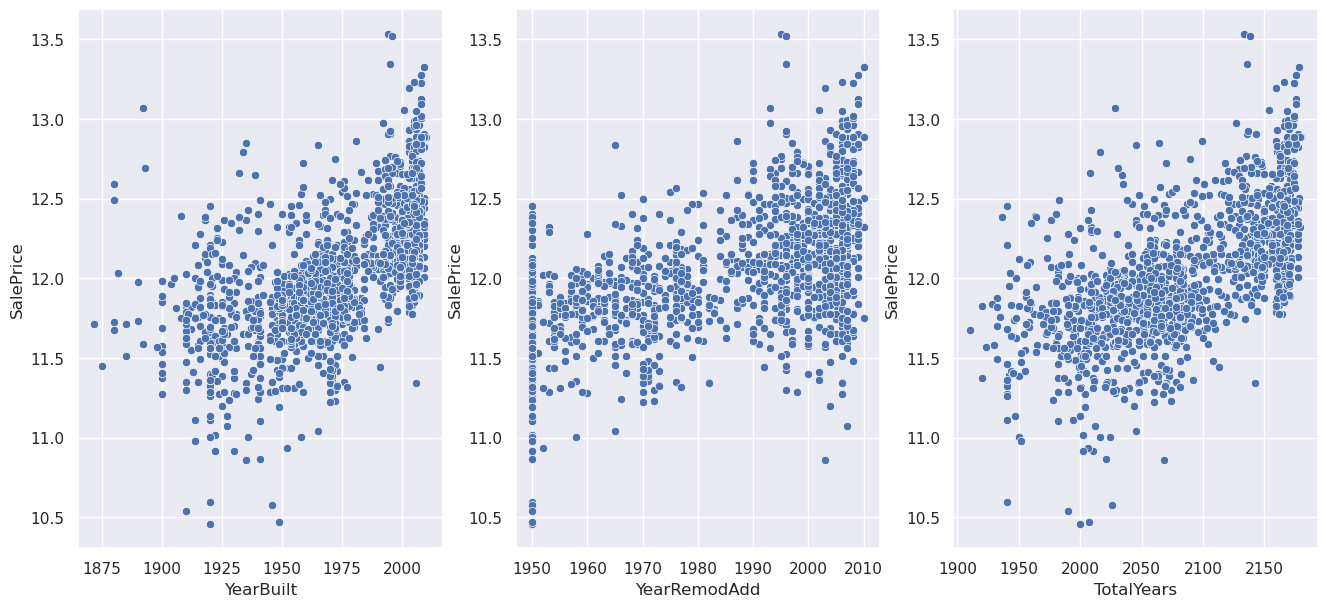

In [1332]:
#Displaying the scatter plot distributions for data after training data with the attributes selected
fig, ax = plt.subplots(1,3, figsize =(16, 7))
sns.scatterplot(x=train_dat['YearBuilt'], y= train_dat['SalePrice'], ax=ax[0])
sns.scatterplot(x=train_dat['YearRemodAdd'], y= train_dat['SalePrice'], ax=ax[1])
sns.scatterplot(x=train_dat['TotalYears'], y= train_dat['SalePrice'], ax=ax[2])

<AxesSubplot:xlabel='2ndFlrSF', ylabel='SalePrice'>

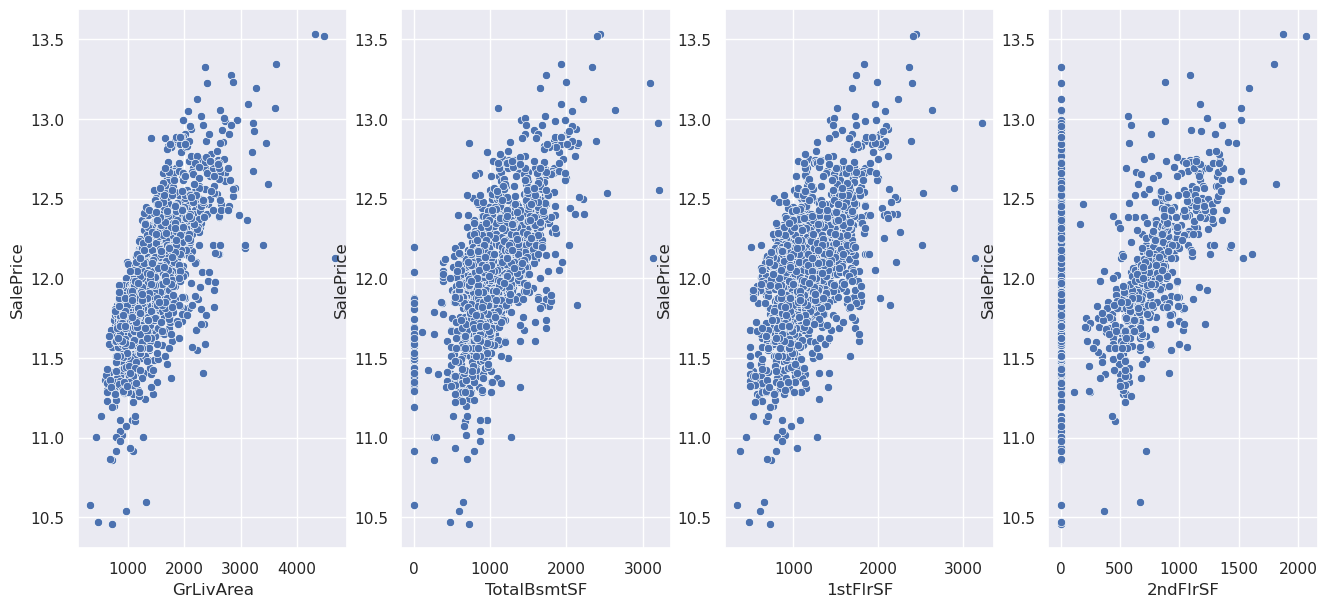

In [1333]:
#scatter plots for the living area, basement and 2 floors aligning with the sale price
fig, ax = plt.subplots(1,4, figsize =(16, 7)) 
sns.scatterplot(x=train_dat['GrLivArea'], y= train_dat['SalePrice'], ax=ax[0])
sns.scatterplot(x=train_dat['TotalBsmtSF'], y= train_dat['SalePrice'], ax=ax[1])
sns.scatterplot(x=train_dat['1stFlrSF'], y= train_dat['SalePrice'], ax=ax[2])
sns.scatterplot(x=train_dat['2ndFlrSF'], y= train_dat['SalePrice'], ax=ax[3])

rLivArea: Above grade (ground) living area square feet.
TotalBsmtSF: Total square feet of basement area.
1stFlrSF: First Floor square feet.
2ndFlrSF: Second floor square feet.
Each plot shows the relationship between the corresponding variable and SalePrice, which can provide insights into how these variables affect the sale price of houses.

The first plot shows a strong positive correlation between the living area and the sale price, indicating that larger living areas tend to fetch higher prices. The second plot shows a similar positive correlation between the total basement area and sale price. The third plot, which shows the first floor square footage against sale price, also shows a positive correlation, but the relationship is not as strong as in the first two plots. Finally, the fourth plot shows the second floor square footage against sale price, and it shows a weaker positive correlation than the other three plots.

train_dat = train_dat[(train_dat['GrLivArea'] < 3500)]
train_dat = train_dat[(train_dat['TotalBsmtSF'] < 3000)]
train_dat = train_dat[(train_dat['1stFlrSF'] < 2500)]
train_dat = train_dat[(train_dat['2ndFlrSF'] < 1600)]

In [1334]:
train_dat = train_dat.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1)
test_dat = test_dat.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1)

In [1335]:
#train dat combines the correlated columns and training the model again for better results
train_dat['OverallSF'] = train_dat['GrLivArea']+train_dat['TotalBsmtSF']
train_dat['TopFlrSF'] = train_dat['1stFlrSF']+train_dat['2ndFlrSF']
test_dat['OverallSF'] = test_dat['GrLivArea']+test_dat['TotalBsmtSF']
test_dat['TopFlrSF'] = test_dat['1stFlrSF']+test_dat['2ndFlrSF']

<AxesSubplot:xlabel='2ndFlrSF', ylabel='SalePrice'>

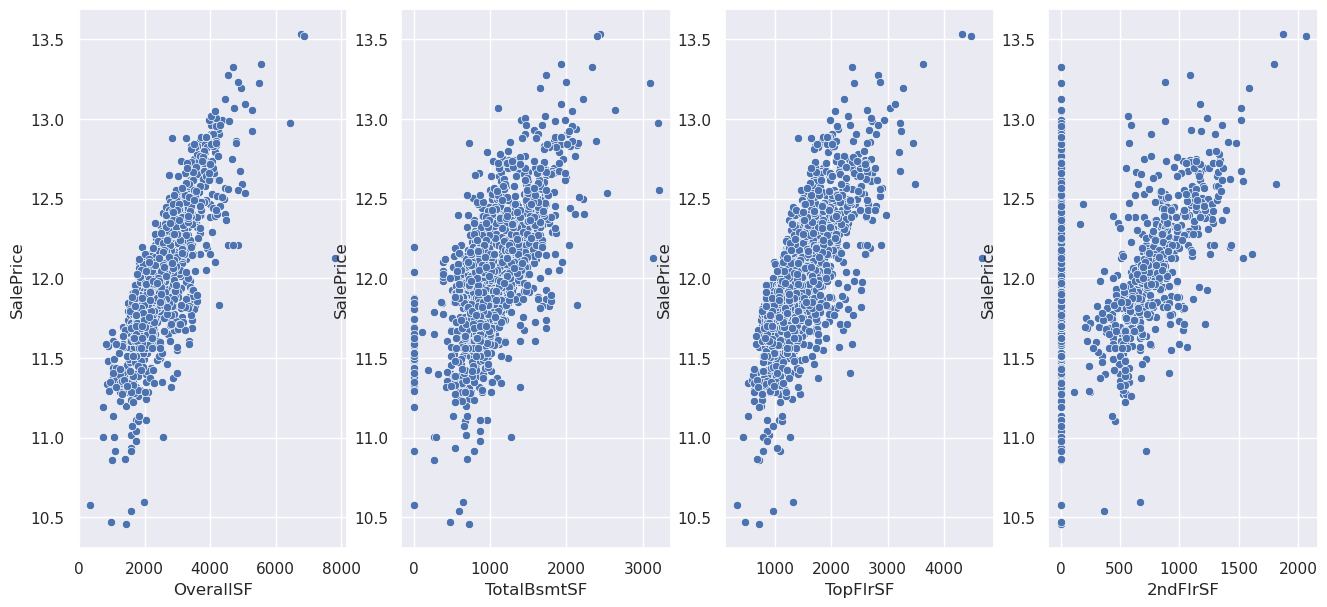

In [1336]:
fig, ax = plt.subplots(1,4, figsize =(16, 7)) #plotting for the scatterplot on various floors square feet
sns.scatterplot(x=train_dat['OverallSF'], y= train_dat['SalePrice'], ax=ax[0])
sns.scatterplot(x=train_dat['TotalBsmtSF'], y= train_dat['SalePrice'], ax=ax[1])
sns.scatterplot(x=train_dat['TopFlrSF'], y= train_dat['SalePrice'], ax=ax[2])
sns.scatterplot(x=train_dat['2ndFlrSF'], y= train_dat['SalePrice'], ax=ax[3])

The above trained data is displayed in the form of scatter plots each scatter plot shows the basement related values effecting the sale price which is more normalised eliminating the outliers.

In [1337]:
# dropping the un needed columns
train_dat = train_dat.drop(['GrLivArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1)
test_dat = test_dat.drop(['GrLivArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1)

<AxesSubplot:xlabel='HalfBath', ylabel='SalePrice'>

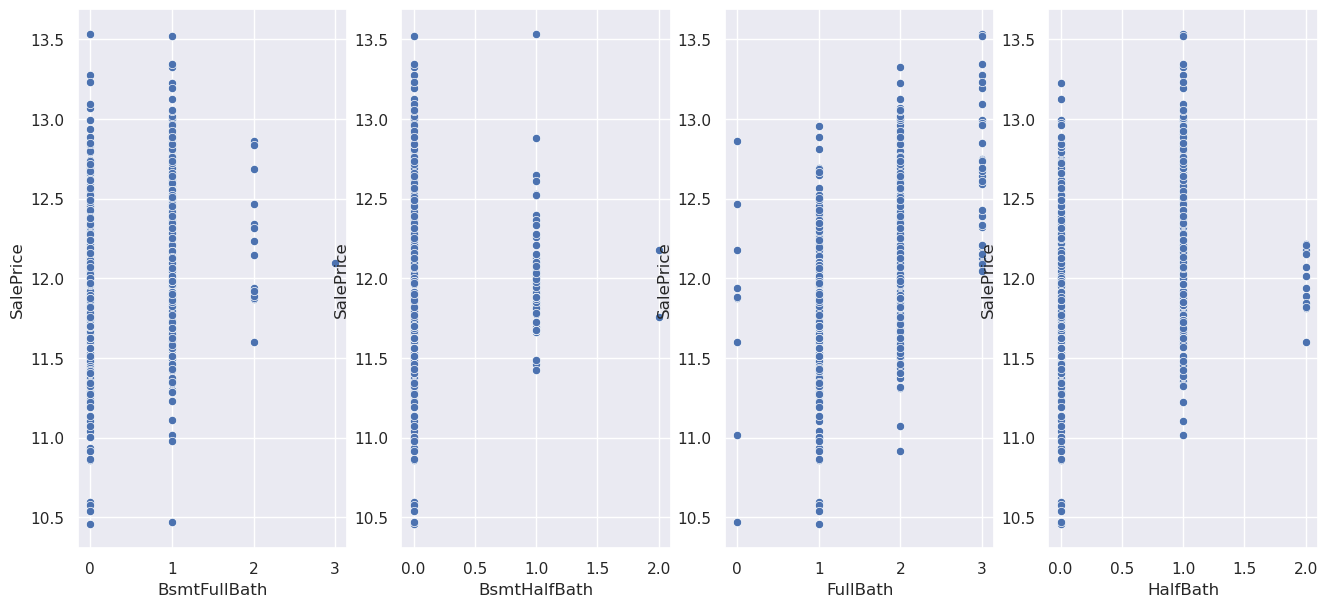

In [1338]:
# scatterplot showing the results based on sale price on bathrooms
fig, ax = plt.subplots(1,4, figsize =(16, 7))
sns.scatterplot(x=train_dat['BsmtFullBath'], y= train_dat['SalePrice'], ax=ax[0])
sns.scatterplot(x=train_dat['BsmtHalfBath'], y= train_dat['SalePrice'], ax=ax[1])
sns.scatterplot(x=train_dat['FullBath'], y= train_dat['SalePrice'], ax=ax[2])
sns.scatterplot(x=train_dat['HalfBath'], y= train_dat['SalePrice'], ax=ax[3])

<AxesSubplot:xlabel='TotalBath', ylabel='SalePrice'>

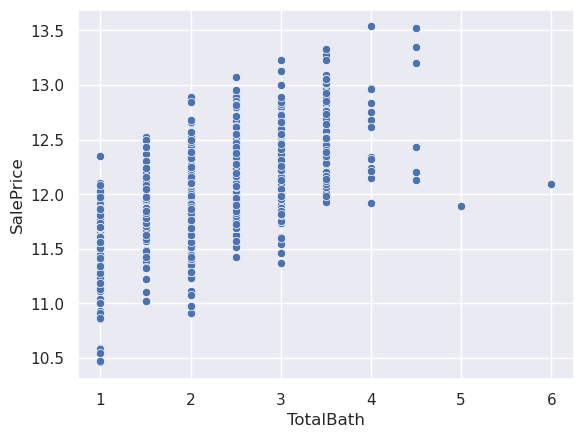

In [1339]:
# sale price which is the y axis and total bath which consits all attributes related to bath
train_dat['TotalBath'] = train_dat['FullBath']+train_dat['BsmtFullBath']+(train_dat['HalfBath']/2)+(train_dat['BsmtHalfBath']/2)
test_dat['TotalBath'] = test_dat['FullBath']+test_dat['BsmtFullBath']+(test_dat['HalfBath']/2)+(test_dat['BsmtHalfBath']/2)
sns.scatterplot(x=train_dat['TotalBath'], y= train_dat['SalePrice'])

The columns related to the bathroom attribute are combined together as basement full bath, half bath to total bath and predicting the effect of sale price which shows mre uniform and clean distribution.

<AxesSubplot:xlabel='TotalBath', ylabel='SalePrice'>

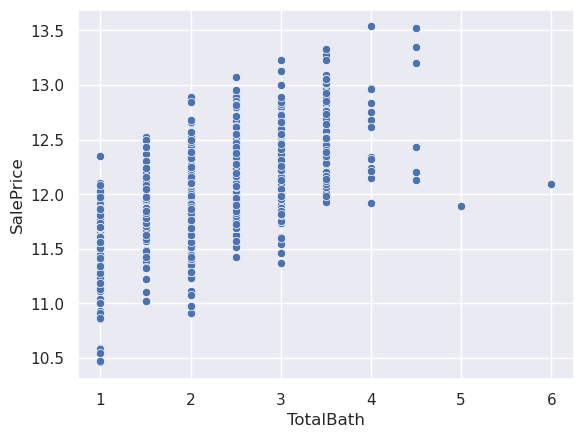

In [1340]:
train_dat['TotalBath'] = train_dat['FullBath']+train_dat['BsmtFullBath']+(train_dat['HalfBath']/2)+(train_dat['BsmtHalfBath']/2)
test_dat['TotalBath'] = test_dat['FullBath']+test_dat['BsmtFullBath']+(test_dat['HalfBath']/2)+(test_dat['BsmtHalfBath']/2)
sns.scatterplot(x=train_dat['TotalBath'], y= train_dat['SalePrice'])

In [1341]:
#dropping the attributes related to bath
train_dat = train_dat.drop(['FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath'], axis=1)
test_dat = test_dat.drop(['FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath'], axis=1)

In [1342]:
#train_dat = train_dat[(train_dat['TotalBath'] < 5)] #training the data with bath less than 5

<AxesSubplot:xlabel='ScreenPorch', ylabel='SalePrice'>

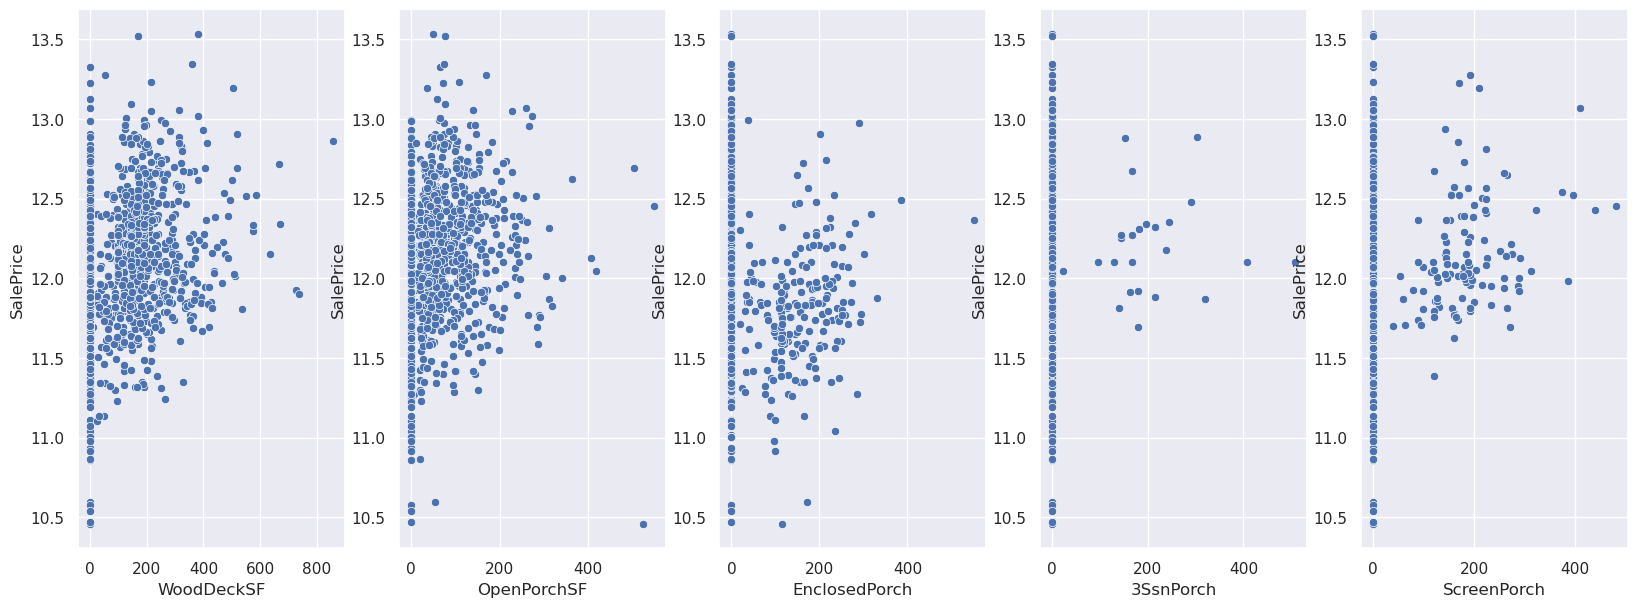

In [1343]:
fig, ax = plt.subplots(1,5, figsize =(20, 7)) #scatter plot 
sns.scatterplot(x=train_dat['WoodDeckSF'], y= train_dat['SalePrice'], ax=ax[0])
sns.scatterplot(x=train_dat['OpenPorchSF'], y= train_dat['SalePrice'], ax=ax[1])
sns.scatterplot(x=train_dat['EnclosedPorch'], y= train_dat['SalePrice'], ax=ax[2])
sns.scatterplot(x=train_dat['3SsnPorch'], y= train_dat['SalePrice'], ax=ax[3])
sns.scatterplot(x=train_dat['ScreenPorch'], y= train_dat['SalePrice'], ax=ax[4])

train_dat = train_dat[(train_dat['WoodDeckSF'] < 600)]
train_dat = train_dat[(train_dat['OpenPorchSF'] < 400)]
train_dat = train_dat[(train_dat['EnclosedPorch'] < 310)]
train_dat = train_dat[(train_dat['3SsnPorch'] < 400)]
train_dat = train_dat[(train_dat['ScreenPorch'] < 390)]

displays a scatter plot of the five porch-related features (WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, and ScreenPorch) against the SalePrice of houses in the housing dataset.

For WoodDeckSF and OpenPorchSF, there seems to be a positive linear relationship between the feature and SalePrice. As the size of these porches increases, the SalePrice of the house tends to increase as well.
For EnclosedPorch, 3SsnPorch, and ScreenPorch, there doesn't seem to be any strong linear relationship between the feature and SalePrice. However, there are some houses with a high SalePrice that have a relatively large EnclosedPorch or ScreenPorch, but these seem to be outliers

In [1344]:
train_dat['OpenPorchSF'].nlargest(3)

1328    547
495     523
583     502
Name: OpenPorchSF, dtype: int64

<AxesSubplot:xlabel='TotalDeckPorch', ylabel='SalePrice'>

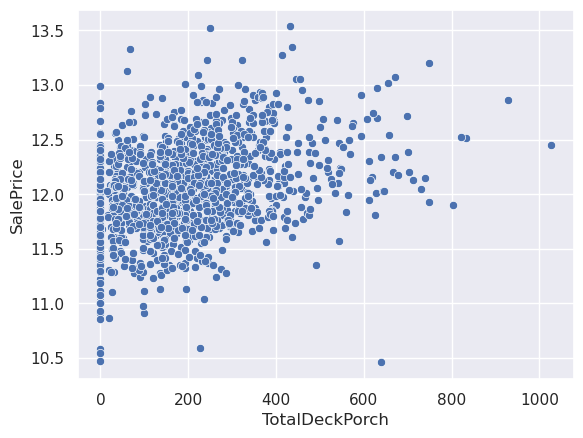

In [1345]:
train_dat['TotalDeckPorch'] = train_dat['WoodDeckSF']+train_dat['OpenPorchSF']+train_dat['EnclosedPorch']+train_dat['3SsnPorch']+train_dat['ScreenPorch']
test_dat['TotalDeckPorch'] = test_dat['WoodDeckSF']+test_dat['OpenPorchSF']+test_dat['EnclosedPorch']+test_dat['3SsnPorch']+test_dat['ScreenPorch']
sns.scatterplot(x=train_dat['TotalDeckPorch'], y= train_dat['SalePrice'])            

In [1346]:
train_dat = train_dat.drop(['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis=1)
test_dat = test_dat.drop(['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis=1)


In [1347]:
cols_to_convert = ['MSSubClass', 'YrSold', 'MoSold', 'TotalBath', 'KitchenAbvGr', 'OverallCond', 'TotRmsAbvGrd', 'Fireplaces', 'OverallQual', 'BedroomAbvGr', 'GarageCars']

for col in cols_to_convert:
    train_dat[col] = train_dat[col].apply(str)
    test_dat[col] = test_dat[col].apply(str)

In [1348]:
#train_dat = train_dat[(train_dat['TotalDeckPorch'] < 800)]

EVALUATING WHAT WE DID? 
Can be checked through the below heatmap.

<AxesSubplot:>

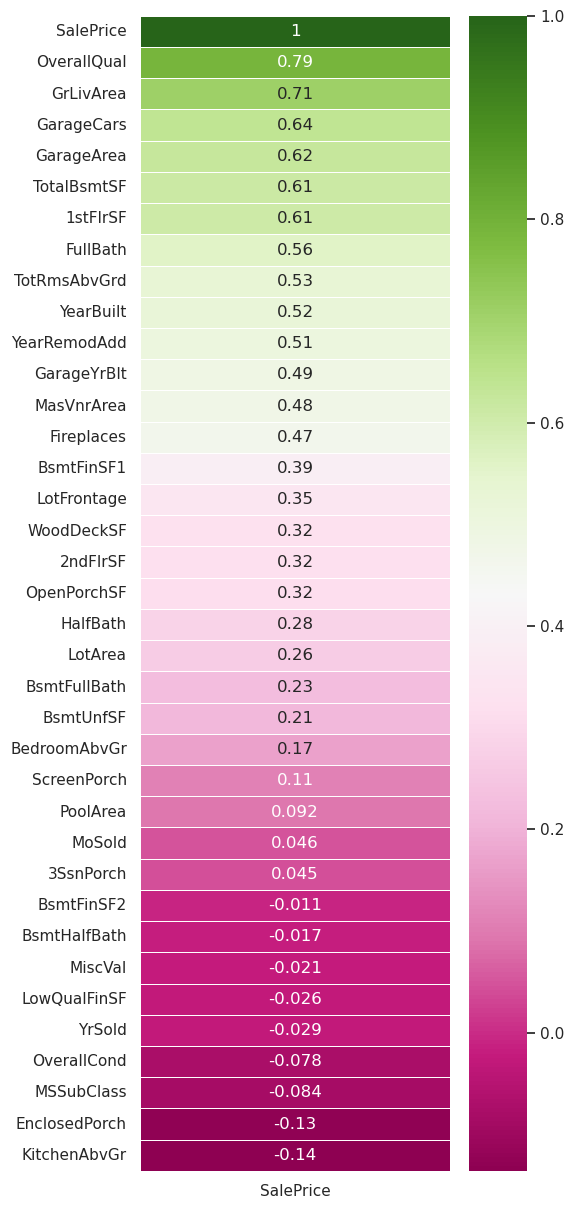

In [1349]:
plt.figure(figsize=(5,15))
sns.heatmap(cor_mat[['SalePrice']].sort_values(by=['SalePrice'], ascending=False), cmap="PiYG", annot=True, linewidths=0.5)

This code displays a heatmap of the correlation matrix between the target variable, SalePrice, and all the other features in the dataset. The correlation values are sorted in descending order based on their correlation with SalePrice.

The heatmap shows that OverallQual has the highest positive correlation with SalePrice, followed by GrLivArea, GarageCars, GarageArea, TotalBsmtSF, and 1stFlrSF. On the other hand, features such as KitchenAbvGr, EnclosedPorch, and MSSubClass have the lowest correlation with SalePrice.

By checking the results based on the sale price we see that overall quality have the highest correlated with the sale price.

<AxesSubplot:>

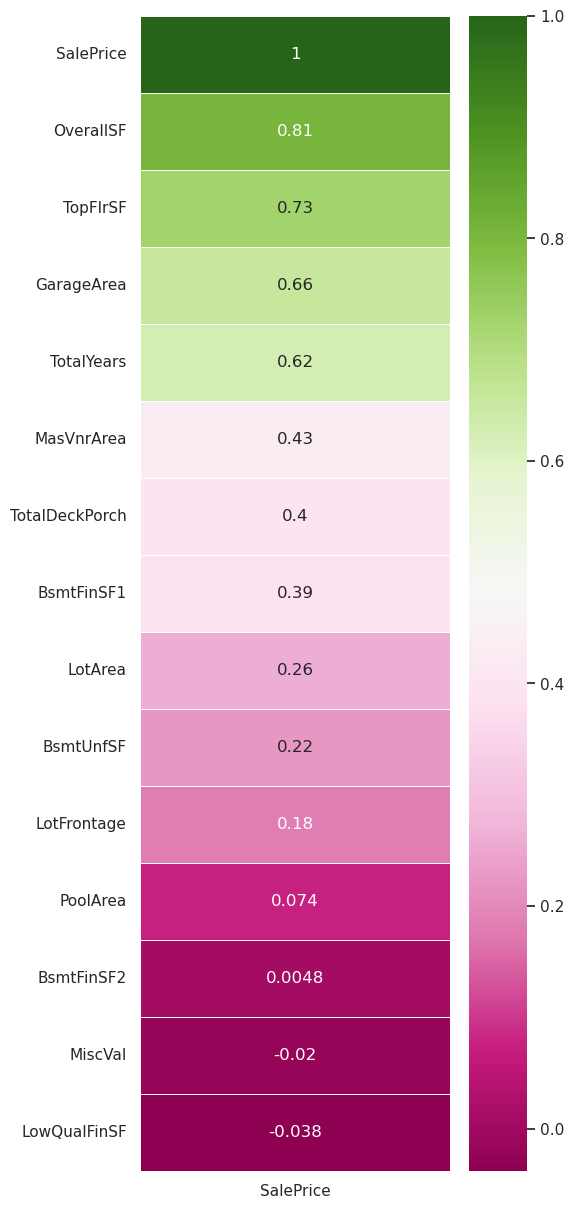

In [1350]:
corr_matrix_3 = train_dat.corr('pearson') # sorting in the descending order with correlation 
plt.figure(figsize=(5,15))
sns.heatmap(corr_matrix_3[['SalePrice']].sort_values(by=['SalePrice'], ascending=False), cmap="PiYG", annot=True, linewidths=0.5)

CHECKING SKEWNESS

Skewness is a measure of the asymmetry of a probability distribution. It tells us how much a distribution deviates from symmetry around its mean. Skewness is important in data analysis because it provides information about the shape of the distribution and helps us to understand the data better.

Distributional assumptions: Skewness is an important consideration when making assumptions about the distribution of data. Many statistical methods assume that the data are normally distributed or have a symmetric distribution. If the data are highly skewed, these assumptions may not hold, and alternative methods may need to be used.

Outlier detection: Skewed data can be an indication of the presence of outliers. Outliers are data points that are very different from the majority of the data and can have a large impact on statistical analyses. By examining skewness, we can identify whether there are outliers in the data that need to be investigated further.

Data transformation: Skewness can also be used to guide data transformation. If the data are highly skewed, we may need to transform the data to achieve a more normal distribution. This can help to improve the accuracy and reliability of statistical analyses.

In [1351]:
# displaying the numerical feautres 
numerical_features = train_dat.select_dtypes(exclude = ["object"]).columns
print(numerical_features)

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'LowQualFinSF', 'GarageArea', 'PoolArea', 'MiscVal',
       'SalePrice', 'TotalYears', 'OverallSF', 'TopFlrSF', 'TotalDeckPorch'],
      dtype='object')


In [1352]:
#using the lamba skewness on the numerical skewness raining from high to low skewness
skewed_features = train_dat[numerical_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.5]
skew_index = high_skew.index
skew_index

Index(['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', 'BsmtFinSF2',
       'MasVnrArea', 'TotalDeckPorch', 'TopFlrSF', 'OverallSF', 'BsmtUnfSF',
       'BsmtFinSF1'],
      dtype='object')

The code identifies the numerical features in the train_dat dataset, computes their skewness values using the skew() function, and then selects the features with a skewness value greater than 0.5, indicating a significant degree of skewness. Finally, it stores the index of those features in the skew_index variable for further processing, such as applying a transformation to reduce their skewness.lambda is a keyword used to create anonymous functions, which are also known as lambda functions. Lambda functions are small, one-line functions that do not require a name or a return statement.

In [1353]:
#the first 5 against SalePrice

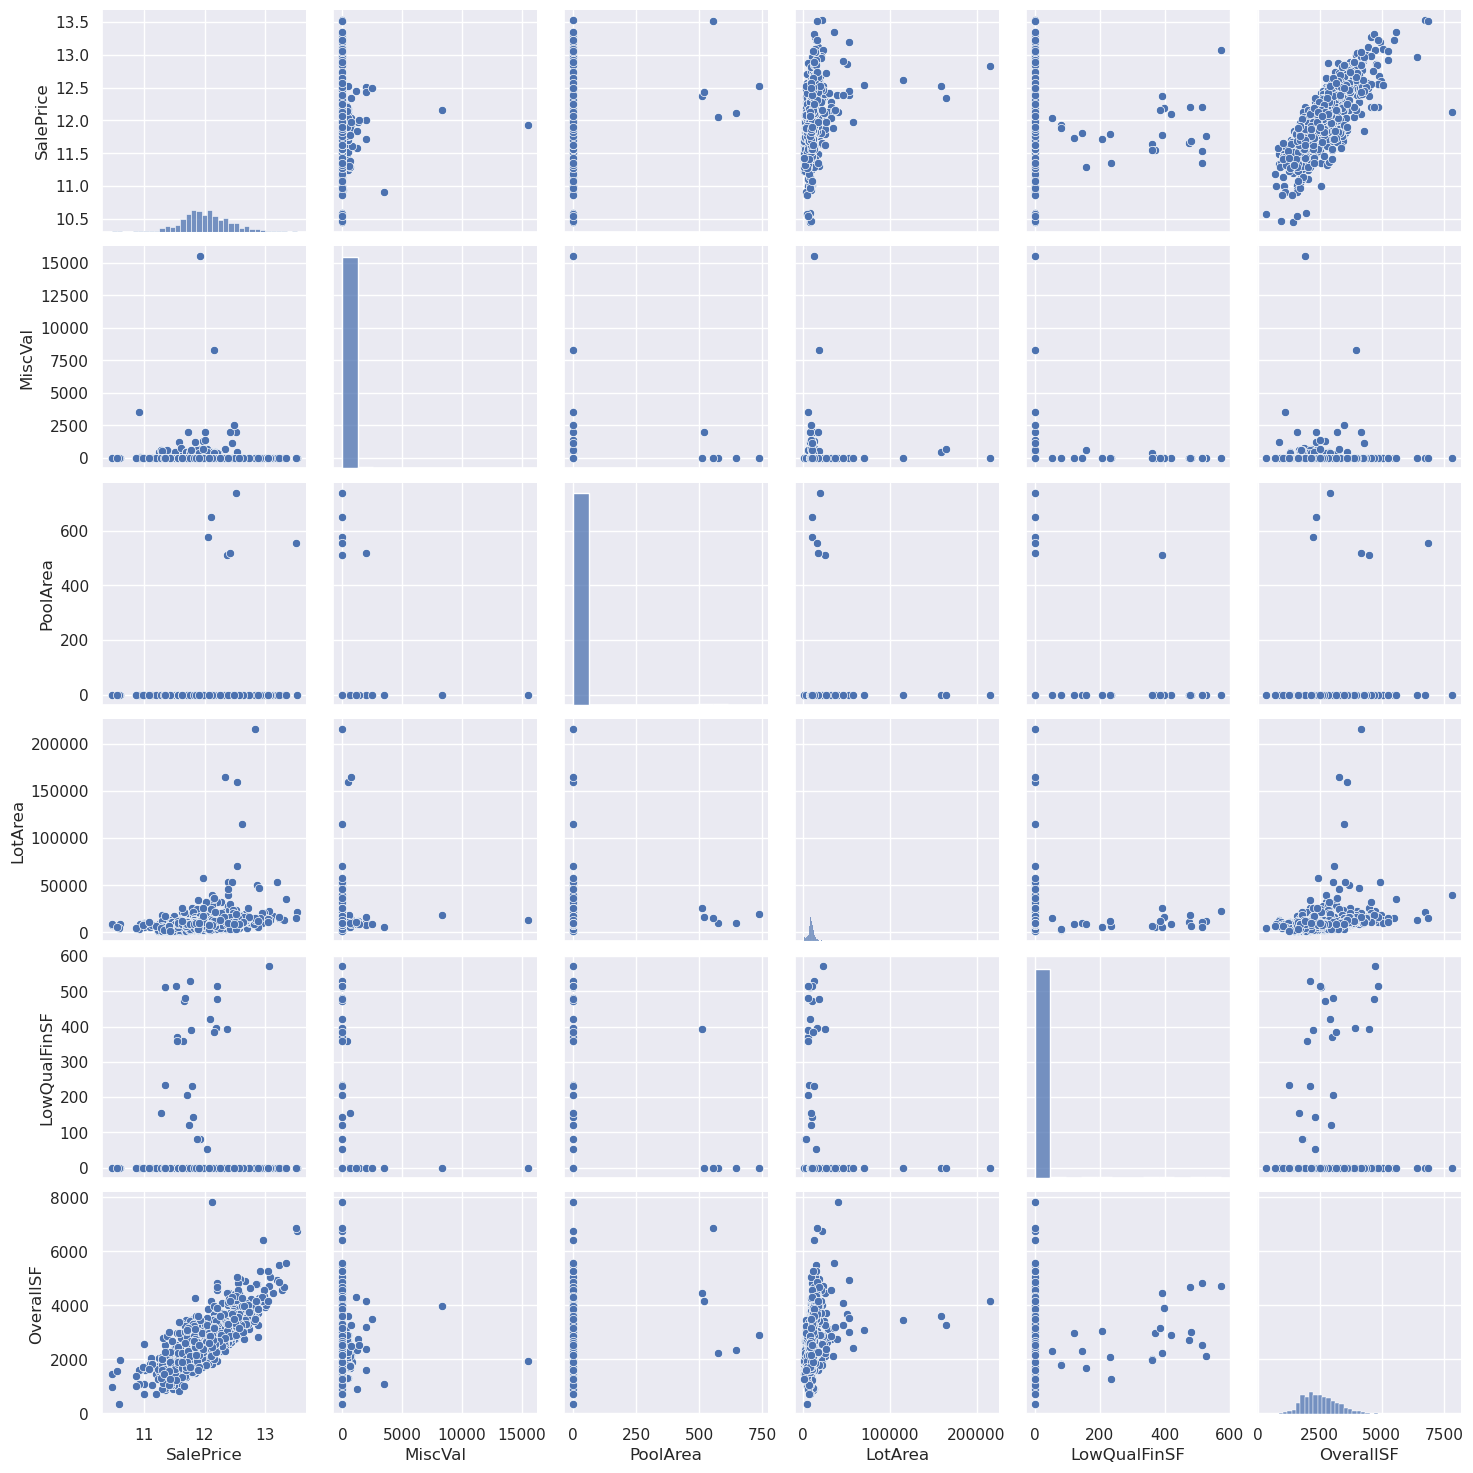

In [1354]:
#scatterplot
cols_pair_1 = ['SalePrice', 'MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', 'OverallSF']
sns.set()
sns.pairplot(train_dat[cols_pair_1], size = 2.5)
plt.show();

the columns are 'SalePrice', 'MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', and 'OverallSF'. The pairplot displays scatterplots for all possible pairs of these variables, as well as histograms along the diagonal showing the distribution of each variable.

By examining the scatterplots, we can see how each variable relates to the others, visually inspecting for any correlations or patterns that may exist. For example, we can see that 'SalePrice' is positively correlated with 'LotArea' and 'OverallSF', which suggests that larger lots and homes tend to sell for more money. We can also see that 'PoolArea' and 'MiscVal' are not strongly related to 'SalePrice', as there does not appear to be any clear pattern or correlation between them.

The histograms along the diagonal show the distribution of each variable individually. This can help us identify any skewed or unusual distributions that may need to be addressed during feature engineering. For example, we can see that 'MiscVal' and 'LowQualFinSF' have highly skewed distributions, suggesting that they may not be very informative features for predicting 'SalePrice'.

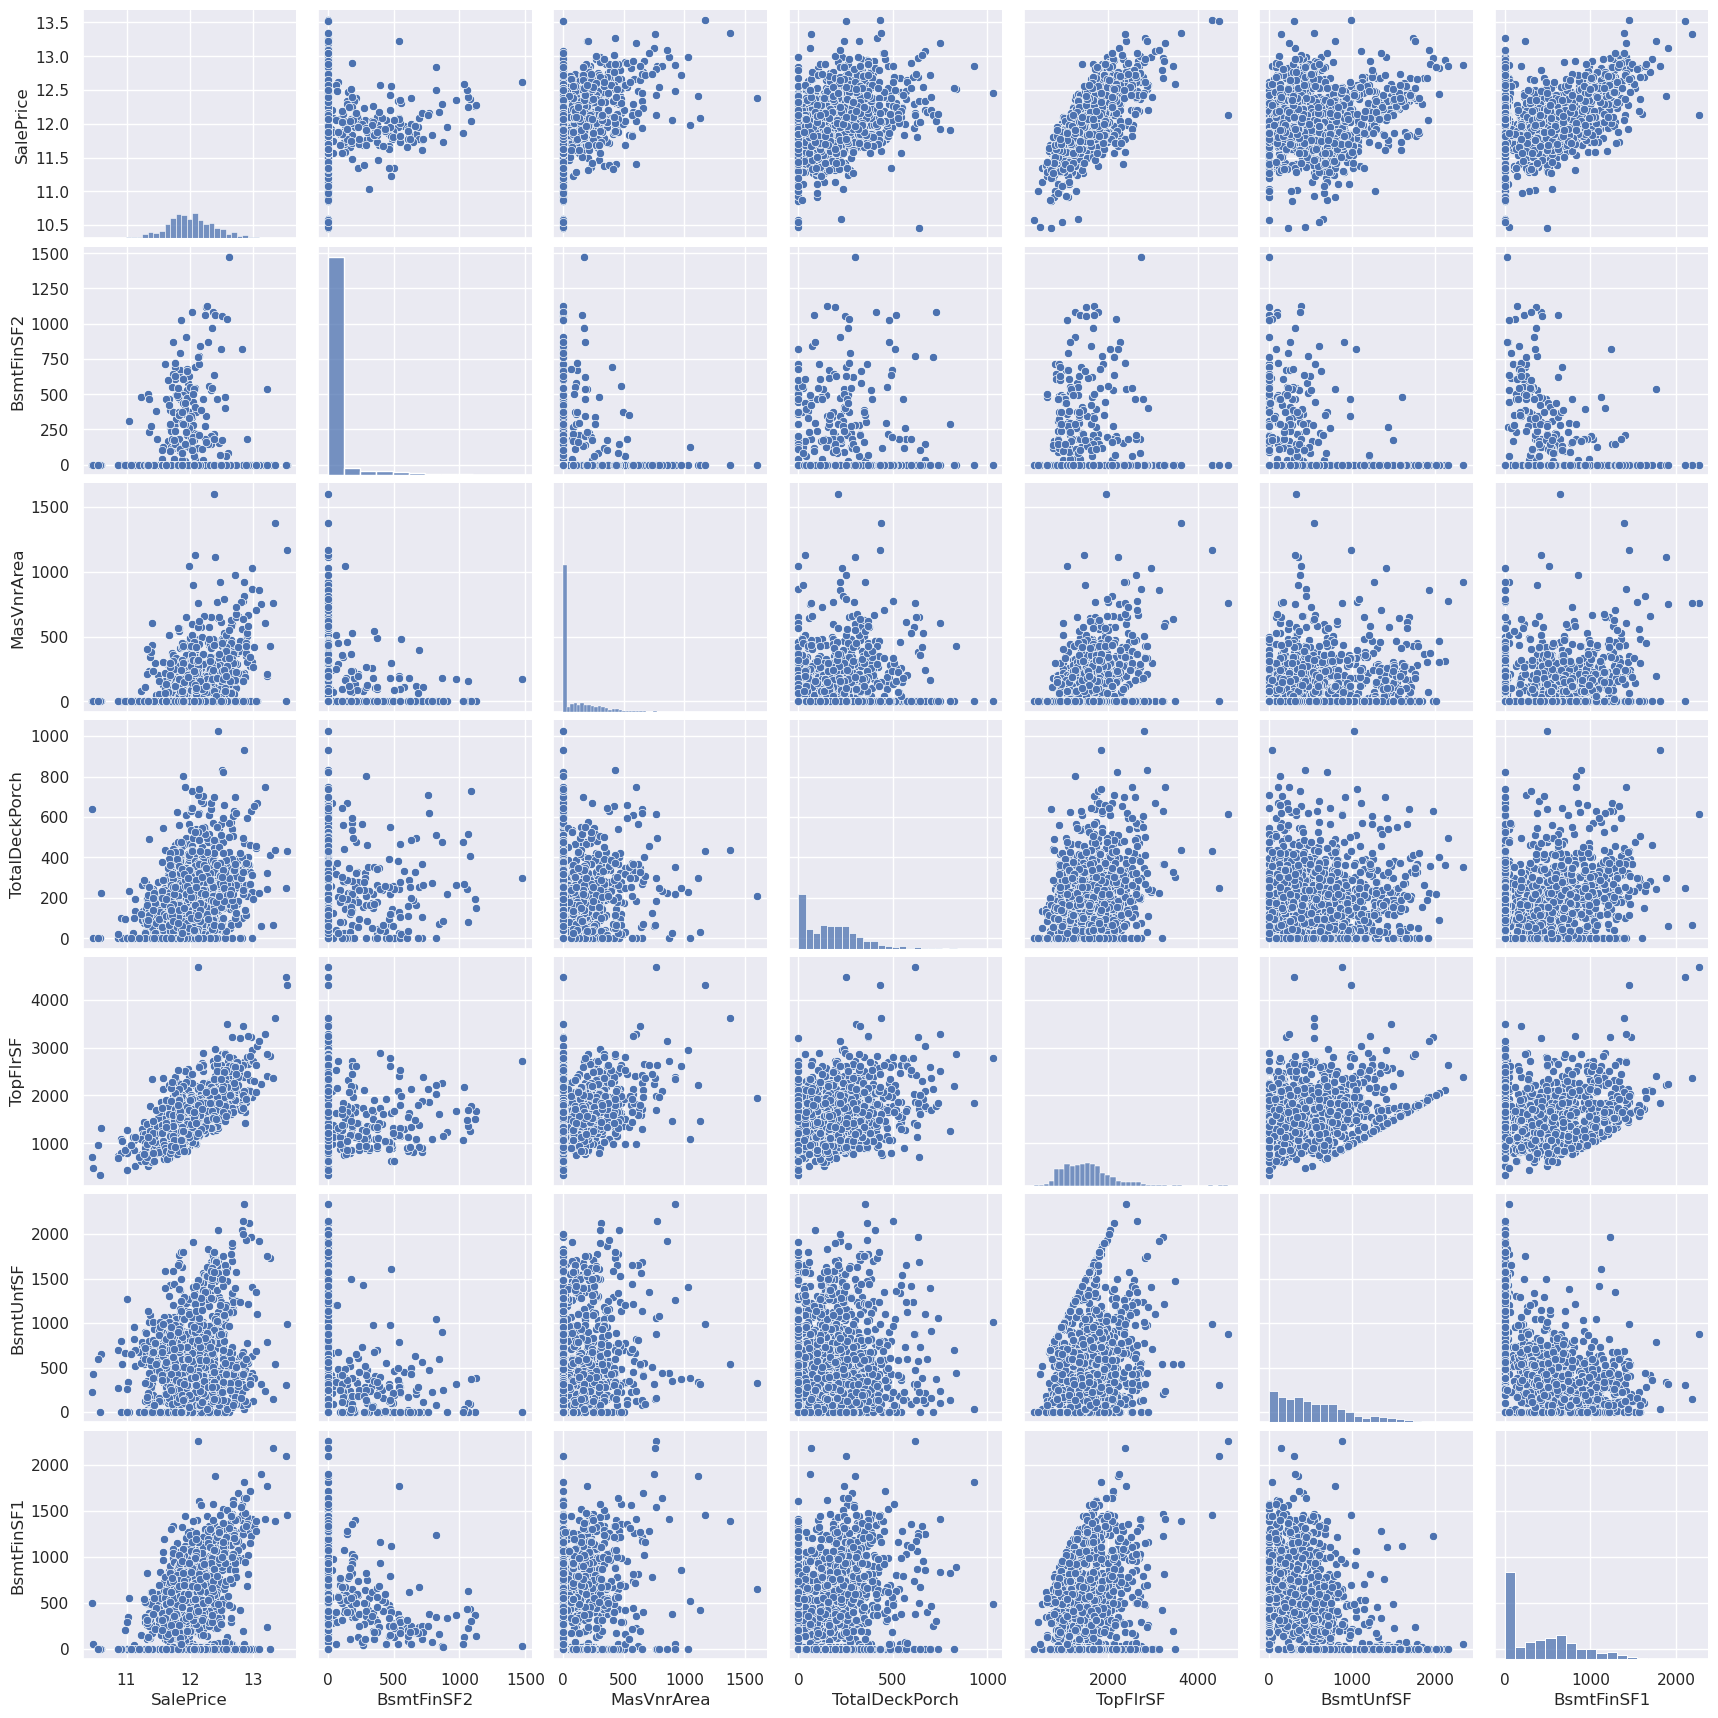

In [1355]:
#scatterplot
cols_pair_2 = ['SalePrice', 'BsmtFinSF2', 'MasVnrArea', 'TotalDeckPorch', 'TopFlrSF', 'BsmtUnfSF', 'BsmtFinSF1']
sns.set()
sns.pairplot(train_dat[cols_pair_2], size = 2.5)
plt.show();

In [1356]:
test_dat['MiscValPresent'] = 0 
test_dat.loc[test_dat['MiscVal']>0,'MiscValPresent'] = 1

train_dat['MiscValPresent'] = 0 
train_dat.loc[train_dat['MiscVal']>0,'MiscValPresent'] = 1

train_dat['PoolPresent'] = 0 
train_dat.loc[train_dat['PoolArea']>0,'PoolPresent'] = 1

test_dat['PoolPresent'] = 0 
test_dat.loc[test_dat['PoolArea']>0,'PoolPresent'] = 1
    
train_dat['LowQualFinPresent'] = 0 
train_dat.loc[train_dat['LowQualFinSF']>0,'LowQualFinPresent'] = 1

test_dat['LowQualFinPresent'] = 0 
test_dat.loc[test_dat['LowQualFinSF']>0,'LowQualFinPresent'] = 1

test_dat['LotFrontagePresent'] = 0 
test_dat.loc[test_dat['LotFrontage']>0,'LotFrontagePresent'] = 1

train_dat['LotFrontagePresent'] = 0 
train_dat.loc[train_dat['LotFrontage']>0,'LotFrontagePresent'] = 1
    
train_dat = train_dat.drop(['MiscVal', 'PoolArea', 'LowQualFinSF',"LotFrontage"], axis=1)
test_dat = test_dat.drop(['MiscVal','PoolArea', 'LowQualFinSF',"LotFrontage"], axis=1)

In [1357]:
#after dropping the values printing the imported feautures.
numerical_features = train_dat.select_dtypes(exclude = ["object"]).columns
print(numerical_features)

Index(['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'GarageArea', 'SalePrice', 'TotalYears', 'OverallSF', 'TopFlrSF',
       'TotalDeckPorch', 'MiscValPresent', 'PoolPresent', 'LowQualFinPresent',
       'LotFrontagePresent'],
      dtype='object')


In [1358]:
skewed_features = train_dat[numerical_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.5]
skew_index = high_skew.index
skew_index

Index(['PoolPresent', 'LotArea', 'LowQualFinPresent', 'MiscValPresent',
       'BsmtFinSF2', 'MasVnrArea', 'TotalDeckPorch', 'TopFlrSF', 'OverallSF',
       'BsmtUnfSF', 'BsmtFinSF1', 'LotFrontagePresent'],
      dtype='object')

In [1359]:
for i in skew_index:
    train_dat[i] = boxcox1p(train_dat[i], boxcox_normmax(train_dat[i] + 1))

ONEHOTENCODING CATEGORICAL FEATURES.

One-hot encoding is a technique used to convert categorical features into numerical features that can be used in machine learning models. This is done by creating a new binary column for each unique category in the categorical feature. If a data point belongs to a particular category, then the binary column for that category is set to 1, and all other binary columns are set to 0. For example, if we have a categorical feature "Color" with three unique values (Red, Green, Blue), we would create three new binary columns: "Color_Red", "Color_Green", and "Color_Blue".

One-hot encoding is commonly used in machine learning because many algorithms can only handle numerical data. By converting categorical data into numerical data, we can use these algorithms to make predictions and perform other tasks.



In [1360]:
categorical_features = train_dat.select_dtypes(include = ["object"]).columns
print(categorical_features) #printing the features

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'TotalBath'],
      dtype='object')


In [1361]:
mis_val = train_dat.isnull().sum() #calculating the sum of null values
mis_val = mis_val[mis_val>0]
mis_val

Series([], dtype: int64)

In [1362]:
# Reset the index after dropping some outliers
train_dat = train_dat.reset_index(drop=True)
test_dat = test_dat.reset_index(drop=True)

In [1363]:
# Instantiate the OneHotEncoder Object
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse = False, )
# Apply ohe on data
ohe.fit(train_dat[categorical_features])
cat_ohe = ohe.transform(train_dat[categorical_features])

#Create a Pandas DataFrame of the hot encoded column
ohe_train_dat = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names(input_features = categorical_features))

In [1364]:
train_dat = train_dat.drop(categorical_features, axis=1) #drop function

In [1365]:
#concat with original data and drop original columns
train_dat = pd.concat([train_dat, ohe_train_dat], axis=1)

In [1366]:
print(train_dat.shape) #printing the structure using the shape function
print(test_dat.shape)

(1459, 351)
(1459, 64)


In [1367]:
mis_val = train_dat.isnull().sum()
mis_val = mis_val[mis_val>0]
mis_val

Series([], dtype: int64)

In [1368]:
Corr_final = train_dat.corrwith(train_dat.SalePrice)
Corr_final = Corr_final.abs().sort_values(ascending=False)
cols_final = list(train_dat.corrwith(train_dat.SalePrice)[train_dat.corrwith(train_dat.SalePrice).abs()>0.4].index)

FINAL CORR EVALUATION

Based on dropping the unwated values we have created a list of final correlated values after training the data conducting the further analysis based on the data.

In [1369]:
Corr_final = train_dat.corrwith(train_dat.SalePrice)
Corr_final = Corr_final.abs().sort_values(ascending=False)
cols_final = list(train_dat.corrwith(train_dat.SalePrice)[train_dat.corrwith(train_dat.SalePrice).abs()>0.4].index)

<AxesSubplot:>

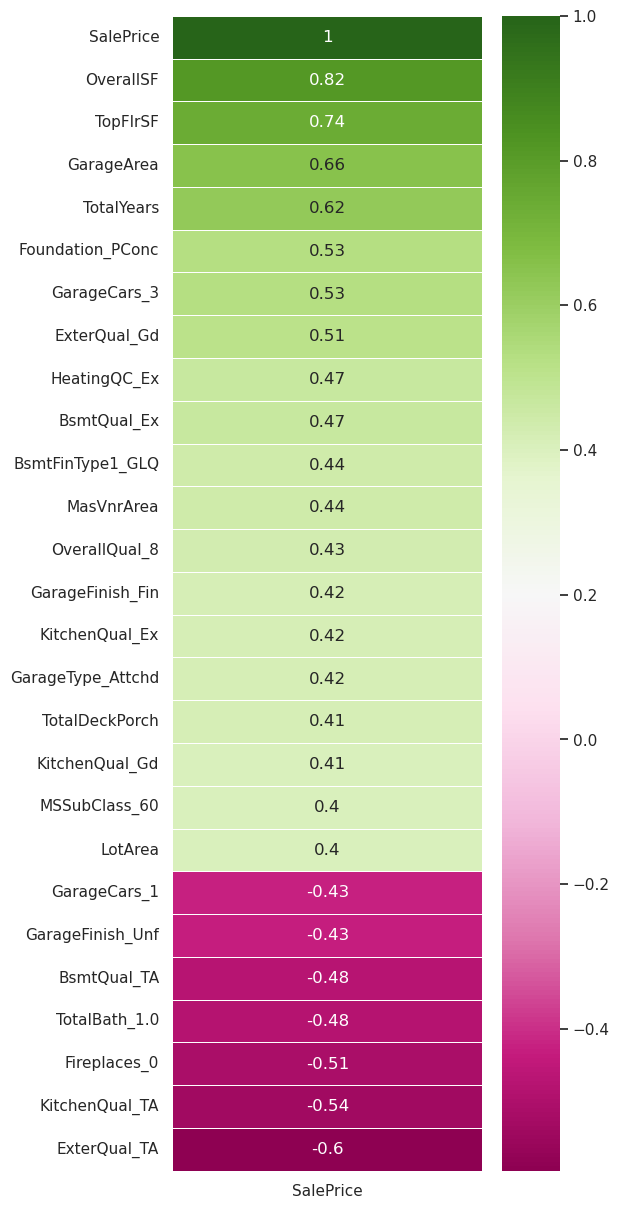

In [1370]:
#displaying the top correlated values with the sale price after training and cleaning the data
corr_matrix_4 = train_dat[cols_final].corr('pearson')
plt.figure(figsize=(5,15))
sns.heatmap(corr_matrix_4[['SalePrice']].sort_values(by=['SalePrice'], ascending=False), cmap="PiYG", annot=True, linewidths=0.5)

Generated the heatmap based on the final train data and we can see the order of correlation from high to low where the sale price is the variable of determination and based on that the high correlated values are overall square feet and top floor square feet, garage area are the top columns which are effecting the sale price hence focusing on these three columns is veru reliable.

In [1371]:
print(train_dat.shape)
print(test_dat.shape)

(1459, 351)
(1459, 64)


In [1372]:
# Import the libraries needed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold

In [1373]:
y = train_dat['SalePrice'] #initialising the train variable for y


In [1374]:

train_dat = train_dat.drop(['SalePrice'], axis=1)

In [1375]:
# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train_dat, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape)) #displaying x and y

X_train : (1021, 350)
X_test : (438, 350)
y_train : (1021,)
y_test : (438,)


In [1376]:
numerical_features_x = [x for i,x in enumerate(numerical_features) if(x!='SalePrice') and (x!='LowQualFinPresent') and (x!='PoolPresent')]
numerical_features_x

['LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'GarageArea',
 'TotalYears',
 'OverallSF',
 'TopFlrSF',
 'TotalDeckPorch',
 'MiscValPresent',
 'LotFrontagePresent']

In [1377]:
stdSc_x= StandardScaler()
stdSc_y= StandardScaler()

X_train[numerical_features_x]  = stdSc_x.fit_transform(X_train[numerical_features_x])
X_test[numerical_features_x]  = stdSc_x.transform(X_test[numerical_features_x])

In [1378]:
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape)) #printing the values and shape of x and y as divided above.

X_train : (1021, 350)
X_test : (438, 350)
y_train : (1021,)
y_test : (438,)


In [1379]:
# Create rsme metric
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

RMSE stands for Root Mean Squared Error, which is a common evaluation metric used in regression analysis to measure the difference between predicted values and actual values. It is calculated by taking the square root of the mean of the squared differences between predicted and actual values.

RMSE is a useful metric in prediction and data analysis because it provides a single numerical value that summarizes the accuracy of a model's predictions. Lower values of RMSE indicate better predictive performance, as they indicate that the model's predicted values are closer to the actual values. RMSE is often used in machine learning to compare the performance of different models or to evaluate the performance of a single model on different subsets of data. It can also be used to identify outliers or to evaluate the overall accuracy of a dataset.

In [1380]:
# 10 fold cross validatoin
kf = KFold(n_splits=10, random_state=42, shuffle=True)

In [1381]:
# Let's use these models 
baseline_models = ['Ridge_Reg.','Lasso_Reg.', 'ElasticNet', 'XGB_Reg.']

In [1382]:
sum_score = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model): # defining the test and train
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = sum_score, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = sum_score, cv = 10))
    return(rmse)

Ridge Regression:

Ridge regression is a regularization technique used to prevent overfitting in linear regression models. It adds a penalty term to the cost function that the model tries to minimize during training. This penalty term, called the regularization parameter (alpha), forces the model to choose smaller coefficients for the features, effectively reducing the model complexity and preventing overfitting.

Ridge regression can be useful in situations where the number of features is large, or when there is a high correlation between features, leading to multicollinearity. In such cases, ordinary least squares (OLS) linear regression can result in unstable and inaccurate predictions. By adding a regularization term, ridge regression can improve the stability and generalization ability of the model, and can help to improve the predictive performance on new, unseen data.

Ridge regression can also be useful in situations where the data is noisy or contains outliers. The penalty term helps to reduce the influence of these points on the model coefficients, and can lead to more robust predictions.

In [1383]:
from sklearn.linear_model import RidgeCV #importing the reg package 
from sklearn.pipeline import make_pipeline, Pipeline #pipeline package

alphas = [8.5, 9, 9.5]
     
ridgecv_reg= RidgeCV(alphas=alphas, cv=kf)
ridgecv_reg.fit(X_train, y_train)
y_test_rdg = ridgecv_reg.predict(X_test)
y_train_rdg = ridgecv_reg.predict(X_train)
alpha = ridgecv_reg.alpha_ #printing best alpha values as ridge outputs
print("Best alpha :", alpha)
print("Now try again for more precision on alpha, with alpha centered around " + str(alpha))
print("Ridge RMSE on Training set :", rmse_cv_train(ridgecv_reg).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridgecv_reg).mean())
print('-'*10+'RidgeCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_test_rdg))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_test_rdg))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_test_rdg))

Best alpha : 8.5
Now try again for more precision on alpha, with alpha centered around 8.5
Ridge RMSE on Training set : 0.12222548298596625
Ridge RMSE on Test set : 0.12561010817522061
----------RidgeCV----------
R square Accuracy:  0.911646054320691
Mean Absolute Error Accuracy:  0.07954799898659584
Mean Squared Error Accuracy:  0.013043415923589412


This output is the result of applying Ridge regression on trained housing dataset. The output indicates that the best alpha value found for the Ridge regression model is 8.5, which means that this value provides the most accurate predictions.

the model has been re-run for more precision on alpha, with alpha centered around 8.5. The RMSE (Root Mean Squared Error) value is calculated for both the training and test sets. The RMSE is a measure of how well the model is fitting the data, with lower values indicating a better fit.

The following section uses RidgeCV, which is a cross-validation method that helps to find the best alpha value by selecting the alpha that provides the highest R square accuracy, lowest mean absolute error, and lowest mean squared error.

The R square accuracy value tells us how much of the variance in the target variable can be explained by the model. The closer this value is to 1, the better the model fits the data. The mean absolute error and mean squared error are other measures of the accuracy of the model's predictions, with lower values indicating better accuracy.

Text(0, 0.5, 'Real values')

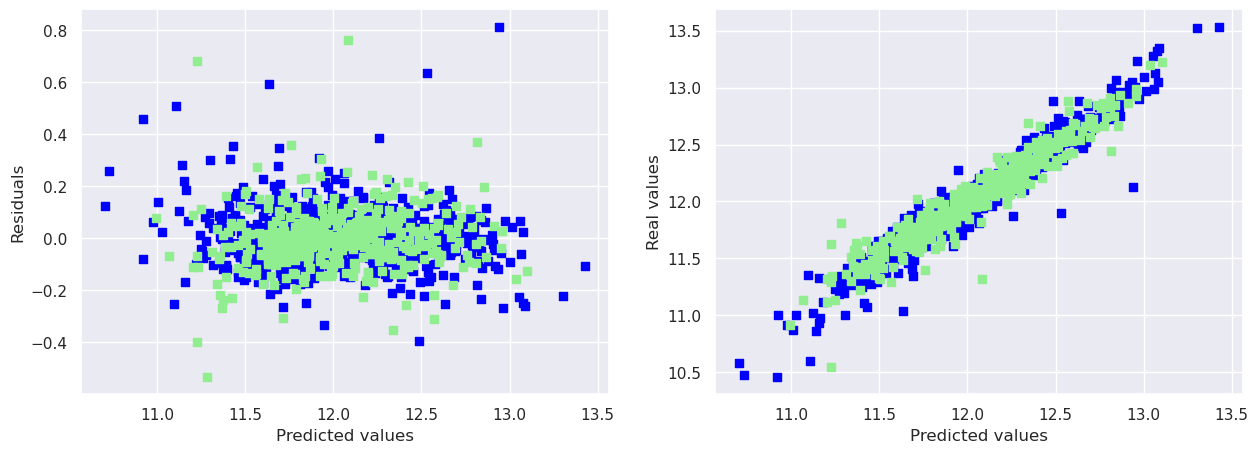

In [1384]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
ax1.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
ax1.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
ax1.set_xlabel("Predicted values")
ax1.set_ylabel("Residuals")

ax2.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
ax2.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Real values")

The first chart on the left shows the residuals of the training data and validation data. The x-axis represents the predicted values, and the y-axis represents the difference between the predicted values and the actual values. The blue points represent the residuals for the training data, while the green points represent the residuals for the validation data. Ideally, the residuals should be normally distributed around 0, with no obvious pattern or trend.

The second chart on the right shows the predicted values versus the real values for both the training and validation data. The x-axis represents the predicted values, while the y-axis represents the actual values. The blue points represent the training data, while the green points represent the validation data. Ideally, the points should be distributed along the diagonal line, which indicates a perfect prediction, but in practice, there will be some deviation from this line. The chart can also help identify outliers and any potential bias in the model's predictions.

RidgeCV picked 340 features and eliminated the other 10 features


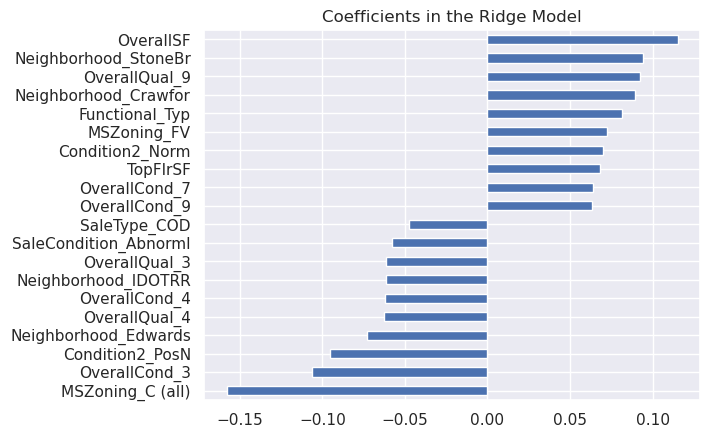

In [1385]:
coefs_rdg = pd.Series(ridgecv_reg.coef_, index = X_train.columns)
print("RidgeCV picked " + str(sum(coefs_rdg != 0)) + " features and eliminated the other " +  str(sum(coefs_rdg == 0)) + " features")
imp_coefs_rdg = pd.concat([coefs_rdg.sort_values().head(10), coefs_rdg.sort_values().tail(10)])
imp_coefs_rdg.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show() 
#the graph dispays the ridge model coeff for the attributes effecting the sale price  ranging -0.075 to 0.1

The code is generating a horizontal bar plot of the coefficients of a Ridge regression model. The plot shows the 10 most negative and 10 most positive coefficients, sorted by their value. The coefficients represent the strength and direction of the relationship between each predictor variable (i.e., each column in X_train) and the target variable.

The y-axis of the plot shows the predictor variable names, and the x-axis shows the coefficient values. Negative coefficients indicate that the predictor variable is negatively associated with the target variable (i.e., as the predictor variable increases, the target variable decreases), while positive coefficients indicate a positive association (i.e., as the predictor variable increases, the target variable also increases).

Lasso regulations

Lasso regression is useful in situations where there are many independent variables in the data set, and some of these variables may not be relevant to the dependent variable. The lasso penalty encourages the coefficients of these irrelevant variables to be reduced to zero, effectively eliminating them from the model.

The tuning parameter alpha controls the strength of the lasso penalty. A higher value of alpha will result in more coefficients being reduced to zero, while a lower value of alpha will result in fewer coefficients being reduced to zero. The optimal value of alpha can be determined through cross-validation techniques.



In [1386]:
from sklearn.linear_model import LassoCV #importing the lasso search 

alphas = [0.0004, 0.0005, 0.0006]

lassocv_reg= LassoCV(alphas=alphas, cv=kf)
lassocv_reg.fit(X_train, y_train)
y_test_lasso=lassocv_reg.predict(X_test)
y_train_lasso = lassocv_reg.predict(X_train)
alpha = lassocv_reg.alpha_
print("Best alpha :", alpha) #printing the values for determination
print("Now try again for more precision on alpha, with alpha centered around" + str(alpha))
print("Ridge RMSE on Training set :", rmse_cv_train(lassocv_reg).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(lassocv_reg).mean())
print('-'*10+'LassoCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_test_lasso))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_test_lasso))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_test_lasso))

Best alpha : 0.0004
Now try again for more precision on alpha, with alpha centered around0.0004
Ridge RMSE on Training set : 0.12039135021189959
Ridge RMSE on Test set : 0.13377317737375827
----------LassoCV----------
R square Accuracy:  0.9044642138917116
Mean Absolute Error Accuracy:  0.07877890186090636
Mean Squared Error Accuracy:  0.014103648503943376


Text(0, 0.5, 'Real values')

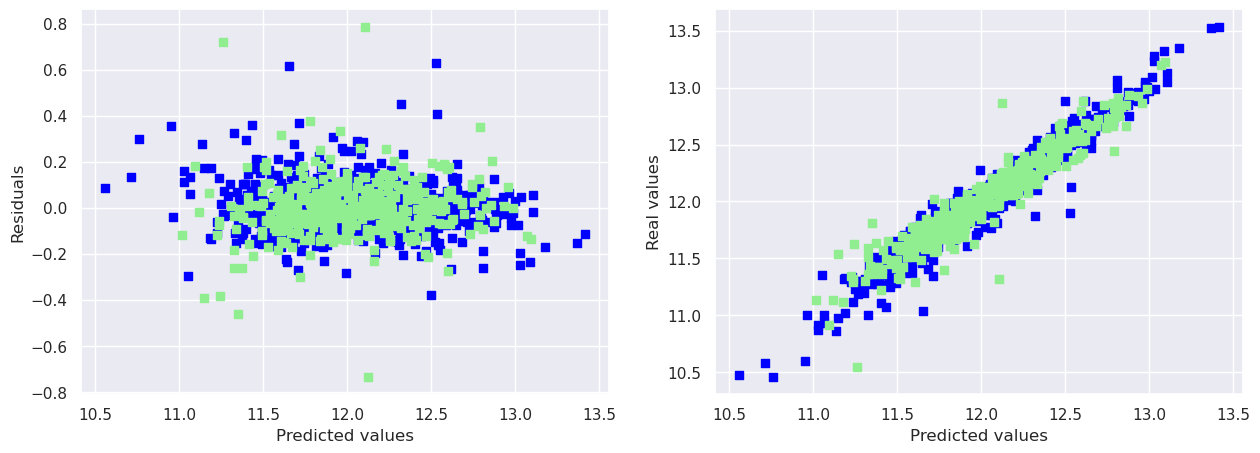

In [1387]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
ax1.scatter(y_train_lasso, y_train_lasso - y_train, c = "blue", marker = "s", label = "Training data")
ax1.scatter(y_test_lasso, y_test_lasso - y_test, c = "lightgreen", marker = "s", label = "Validation data")
ax1.set_xlabel("Predicted values")
ax1.set_ylabel("Residuals")

ax2.scatter(y_train_lasso, y_train, c = "blue", marker = "s", label = "Training data")
ax2.scatter(y_test_lasso, y_test, c = "lightgreen", marker = "s", label = "Validation data")
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Real values")

LassoCV picked 139 features and eliminated the other 211 features


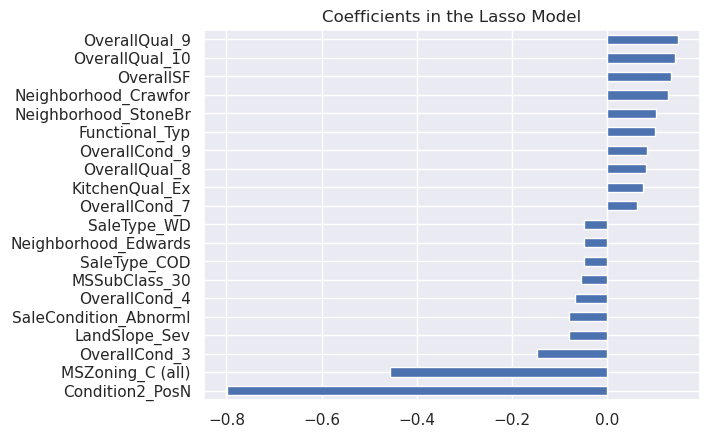

In [1388]:
coefs_lasso = pd.Series(lassocv_reg.coef_, index = X_train.columns)
print("LassoCV picked " + str(sum(coefs_lasso != 0)) + " features and eliminated the other " +  str(sum(coefs_lasso == 0)) + " features")
imp_coefs_lasso = pd.concat([coefs_lasso.sort_values().head(10), coefs_lasso.sort_values().tail(10)])
imp_coefs_lasso.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

Elastic Net Regularization 

Elastic Net is a regularization technique that combines the penalties of L1 (Lasso) and L2 (Ridge) regularization to overcome their limitations. L1 regularization leads to sparse models, where some of the coefficients are exactly zero, while L2 regularization shrinks the coefficients towards zero without making them exactly zero.

The Elastic Net regularization method adds a new hyperparameter, "l1_ratio", which determines the combination of L1 and L2 regularization. When "l1_ratio" is set to 1, it is equivalent to Lasso regularization, and when it is set to 0, it is equivalent to Ridge regularization.



In [1389]:
from sklearn.linear_model import ElasticNetCV #imprting the package

alphas=[0.0004, 0.0005, 0.0006] 
l1ratio=[0.8, 0.9, 1]

elasticv_reg= ElasticNetCV(alphas=alphas, l1_ratio=l1ratio, cv=kf)
elasticv_reg.fit(X_train, y_train)
y_test_elastic=elasticv_reg.predict(X_test)
y_train_elastic = elasticv_reg.predict(X_train)
alpha = elasticv_reg.alpha_
ratio = elasticv_reg.l1_ratio_ #defining the ratios 
print("Best alpha :", alpha)
print("Best l1ratio :", ratio)
print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
print("Elastic RMSE on Training set :", rmse_cv_train(elasticv_reg).mean())
print("Elastic RMSE on Test set :", rmse_cv_test(elasticv_reg).mean())
print('-'*10+'ElasticNetCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_test_elastic))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_test_elastic))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_test_elastic)) #printing the mean square accuracy

Best alpha : 0.0006
Best l1ratio : 0.8
Now try again for more precision on alpha, with l1_ratio fixed at 0.8 and alpha centered around 0.0006
Elastic RMSE on Training set : 0.12052714093107648
Elastic RMSE on Test set : 0.13456630632485728
----------ElasticNetCV----------
R square Accuracy:  0.908613442235357
Mean Absolute Error Accuracy:  0.07804244891652797
Mean Squared Error Accuracy:  0.013491110935507582


Text(0, 0.5, 'Real values')

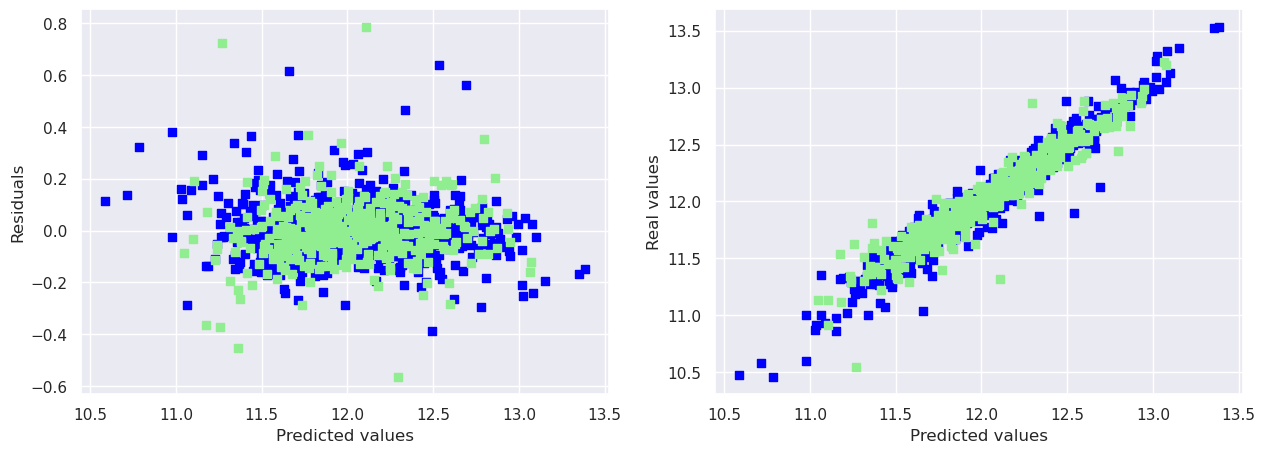

In [1390]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
ax1.scatter(y_train_elastic, y_train_elastic - y_train, c = "blue", marker = "s", label = "Training data")
ax1.scatter(y_test_elastic, y_test_elastic - y_test, c = "lightgreen", marker = "s", label = "Validation data")
ax1.set_xlabel("Predicted values")
ax1.set_ylabel("Residuals")

ax2.scatter(y_train_elastic, y_train, c = "blue", marker = "s", label = "Training data")
ax2.scatter(y_test_elastic, y_test, c = "lightgreen", marker = "s", label = "Validation data")
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Real values")
#plotting the graphs for the real and residual values 

ElasticCV picked 134 features and eliminated the other 216 features


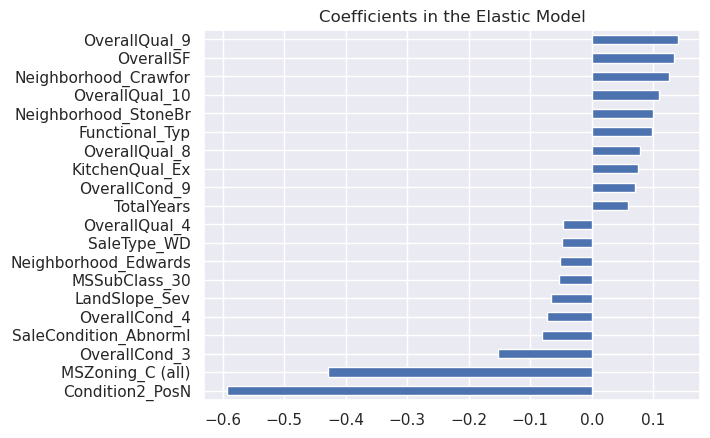

In [1391]:
coefs_elastic = pd.Series(elasticv_reg.coef_, index = X_train.columns)
print("ElasticCV picked " + str(sum(coefs_elastic != 0)) + " features and eliminated the other " +  str(sum(coefs_elastic == 0)) + " features")
imp_coefs_elastic = pd.concat([coefs_elastic.sort_values().head(10), coefs_elastic.sort_values().tail(10)])
imp_coefs_elastic.plot(kind = "barh")
plt.title("Coefficients in the Elastic Model")
plt.show()

XGBoost

XGBoost (eXtreme Gradient Boosting) is a popular implementation of the gradient boosting algorithm. It is a powerful and efficient machine learning model that has been widely used in various fields, including finance, healthcare, and computer vision.

XGBoost uses an ensemble of decision trees, where each subsequent tree learns from the residual errors of the previous tree, resulting in a highly accurate prediction model. It also incorporates regularization techniques to prevent overfitting, such as L1 and L2 regularization.

One of the key benefits of XGBoost is its speed and scalability, as it can handle large datasets with millions of instances and thousands of features. Additionally, it provides a wide range of hyperparameters that can be tuned to optimize the model's performance.



In [1392]:
from xgboost import XGBRegressor #importing the xgboost package 
import xgboost as xgb 
d_train = xgb.DMatrix(data = X_train, 
                       label = y_train) #defining the train

d_test =  xgb.DMatrix(data = X_test,
                       label = y_test) #defining the test

In [1393]:
xgb_model = XGBRegressor()

In [1394]:
search_params = { 
    'max_depth': [2, 3],
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [500, 800]} #listing the depth rate and estimators range

In [1395]:
#from sklearn.model_selection import GridSearchCV #importing the grid search

#GS = GridSearchCV(estimator = xgb_model,
                 #param_grid = search_params,
                 #scoring = ['r2', 'neg_root_mean_squared_error'],
                 #refit = 'r2',
                 #cv = 5, 
                 #verbose = 1)

In [1396]:
#GS.fit(X_train, y_train)
#print(GS.best_params_)
#print(GS.best_estimator_)
#print(GS.best_score_)

In [1397]:
#y_test_xgboost=GS.best_estimator_.predict(X_test)
#y_train_xgboost = GS.best_estimator_.predict(X_train)
#print("XGB RMSE on Training set :", rmse_cv_train(GS.best_estimator_).mean())
#print("XGB RMSE on Test set :", rmse_cv_test(GS.best_estimator_).mean())
#print('R square Accuracy: ',r2_score(y_test,y_test_xgboost))
#print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_test_xgboost))
#print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_test_xgboost))


build a final model

In [1398]:
regressor = XGBRegressor(learning_rate = 0.1,
                         max_depth = 2,
                         n_estimators=800)
regressor.fit(X_train, y_train)
y_test_model=regressor.predict(X_test)
y_train_model = regressor.predict(X_train) #predicting the test and train 

In [1399]:
print("Model RMSE on Training set :", rmse_cv_train(regressor).mean()) #print the rsme train 
print("Model RMSE on Test set :", rmse_cv_test(regressor).mean()) #print rsme test 
print('-'*10+'ElasticNetCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_test_model)) #best accuracy 
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_test_model))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_test_model)) #mse accuracy

Model RMSE on Training set : 0.130659528640987
Model RMSE on Test set : 0.1359672162050965
----------ElasticNetCV----------
R square Accuracy:  0.9092631363892031
Mean Absolute Error Accuracy:  0.08022810225657599
Mean Squared Error Accuracy:  0.013395198625009336


Text(0, 0.5, 'Real values')

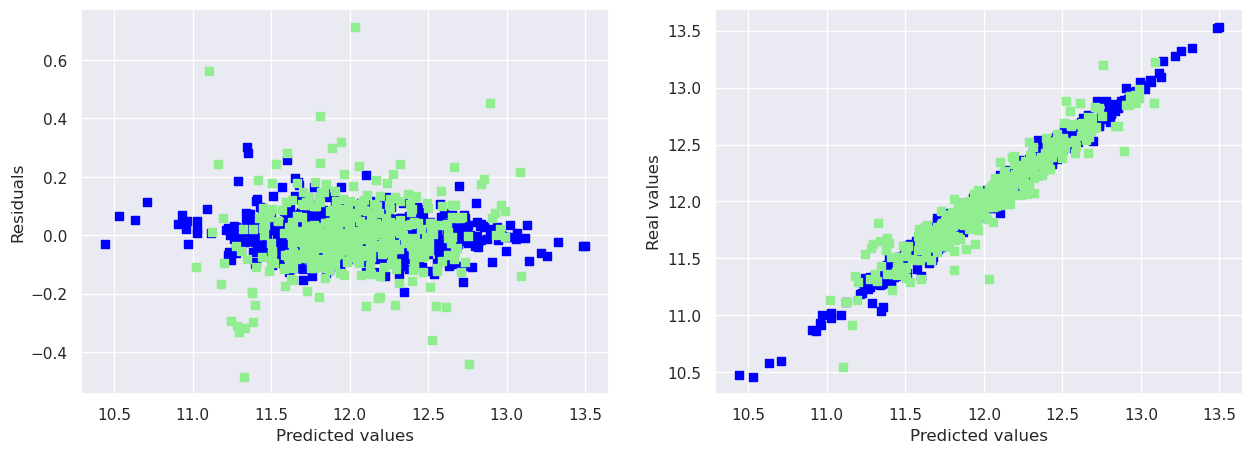

In [1400]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5)) #plotting the subplot based on predictions 
ax1.scatter(y_train_model, y_train_model - y_train, c = "blue", marker = "s", label = "Training data")
ax1.scatter(y_test_model, y_test_model - y_test, c = "lightgreen", marker = "s", label = "Validation data")
ax1.set_xlabel("Predicted values")
ax1.set_ylabel("Residuals")
#scatter plot for predicted residuals and real values 
ax2.scatter(y_train_model, y_train, c = "blue", marker = "s", label = "Training data")
ax2.scatter(y_test_model, y_test, c = "lightgreen", marker = "s", label = "Validation data")
ax2.set_xlabel("Predicted values")
ax2.set_ylabel("Real values")

Predict SalePrice

After all the analysis the final step of the data analysis part is to predict and identify based on the given attributes the range of sale prices on the test data based on the trained best models.

In [1401]:
test_dat.head() #printing the top rows 

Id MSSubClass MSZoning  LotArea Street LotShape LandContour Utilities  \
0  1461         20       RH    11622   Pave      Reg         Lvl    AllPub   
1  1462         20       RL    14267   Pave      IR1         Lvl    AllPub   
2  1463         60       RL    13830   Pave      IR1         Lvl    AllPub   
3  1464         60       RL     9978   Pave      IR1         Lvl    AllPub   
4  1465        120       RL     5005   Pave      IR1         HLS    AllPub   

  LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
0    Inside       Gtl        NAmes      Feedr       Norm     1Fam     1Story   
1    Corner       Gtl        NAmes       Norm       Norm     1Fam     1Story   
2    Inside       Gtl      Gilbert       Norm       Norm     1Fam     2Story   
3    Inside       Gtl      Gilbert       Norm       Norm     1Fam     2Story   
4    Inside       Gtl      StoneBr       Norm       Norm   TwnhsE     1Story   

  OverallQual OverallCond RoofStyle RoofMatl Exterior1st Exterior2nd  \
0           5           6     Gable  CompShg     VinylSd     VinylSd   
1           6           6       Hip  CompShg     Wd Sdng     Wd Sdng   
2           5           5     Gable  CompShg     VinylSd     VinylSd   
3           6           6     Gable  CompShg     VinylSd     VinylSd   
4           8           5     Gable  CompShg     HdBoard     HdBoard   

  MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
0       None         0.0        TA        TA     CBlock       TA       TA   
1    BrkFace       108.0        TA        TA     CBlock       TA       TA   
2       None         0.0        TA        TA      PConc       Gd       TA   
3    BrkFace        20.0        TA        TA      PConc       TA       TA   
4       None         0.0        Gd        TA      PConc       Gd       TA   

  BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  \
0           No          Rec       468.0          LwQ       144.0      270.0   
1           No          ALQ       923.0          Unf         0.0      406.0   
2           No          GLQ       791.0          Unf         0.0      137.0   
3           No          GLQ       602.0          Unf         0.0      324.0   
4           No          ALQ       263.0          Unf         0.0     1017.0   

  Heating HeatingQC CentralAir Electrical BedroomAbvGr KitchenAbvGr  \
0    GasA        TA          Y      SBrkr            2            1   
1    GasA        TA          Y      SBrkr            3            1   
2    GasA        Gd          Y      SBrkr            3            1   
3    GasA        Ex          Y      SBrkr            3            1   
4    GasA        Ex          Y      SBrkr            2            1   

  KitchenQual TotRmsAbvGrd Functional Fireplaces GarageType GarageFinish  \
0          TA            5        Typ          0     Attchd          Unf   
1          Gd            6        Typ          0     Attchd          Unf   
2          TA            6        Typ          1     Attchd          Fin   
3          Gd            7        Typ          1     Attchd          Fin   
4          Gd            5        Typ          0     Attchd          RFn   

  GarageCars  GarageArea GarageQual GarageCond PavedDrive MoSold YrSold  \
0        1.0       730.0         TA         TA          Y      6   2010   
1        1.0       312.0         TA         TA          Y      6   2010   
2        2.0       482.0         TA         TA          Y      3   2010   
3        2.0       470.0         TA         TA          Y      6   2010   
4        2.0       506.0         TA         TA          Y      1   2010   

  SaleType SaleCondition  TotalYears  OverallSF  TopFlrSF TotalBath  \
0       WD        Normal      2038.0     1778.0       896       1.0   
1       WD        Normal      2029.0     2658.0      1329       1.5   
2       WD        Normal      2147.0     2557.0      1629       2.5   
3       WD        Normal      2149.0     2530.0      1604       2

In [1402]:
test_dat.shape #printing the test shape

(1459, 64)

In [1403]:
numerical_features_test_dat = test_dat.select_dtypes(exclude = ["object"]).columns
numerical_features_test_dat = [x for i,x in enumerate(numerical_features_test_dat) if(x!='SalePrice') and (x!='LowQualFinPresent') and (x!='PoolPresent')and (x!='Id')]
print(numerical_features_test_dat) #printing the numeric data feautures 

['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'GarageArea', 'TotalYears', 'OverallSF', 'TopFlrSF', 'TotalDeckPorch', 'MiscValPresent', 'LotFrontagePresent']


In [1404]:
skewed_features = test_dat[numerical_features_test_dat].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.5]
skew_index = high_skew.index
skew_index

Index(['MiscValPresent', 'BsmtFinSF2', 'LotArea', 'MasVnrArea',
       'TotalDeckPorch', 'OverallSF', 'BsmtFinSF1', 'TopFlrSF', 'BsmtUnfSF',
       'LotFrontagePresent'],
      dtype='object')

In [1405]:
for i in skew_index: #for loop to access the test data 
    test_dat[i] = boxcox1p(test_dat[i], boxcox_normmax(test_dat[i] + 1))

In [1406]:
categorical_features #displaying the categorical data 

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'TotalBath'],
      dtype='object')

In [1407]:
# The following code is for your test_dat dataframe after training and test_dating on train_dat dataframe
# Apply ohe on new dataframe
cat_ohe_test_dat = ohe.transform(test_dat[categorical_features])
#Create a Pandas DataFrame of the hot encoded column
ohe_train_dat_test_dat = pd.DataFrame(cat_ohe_test_dat, columns = ohe.get_feature_names(input_features = categorical_features))

test_dat = test_dat.drop(categorical_features, axis=1)
#concat with original data and drop original columns
test_dat = pd.concat([test_dat, ohe_train_dat_test_dat], axis=1)

In [1408]:
print(train_dat.shape)
print(test_dat.shape) #printing the rows and columns of the test and train

(1459, 350)
(1459, 351)


In [1409]:
test_dat.head() #checking the top rows of test data

Id    LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  GarageArea  \
0  1461  50.728192    0.000000   86.954089    7.403205  42.300174       730.0   
1  1462  54.118575   14.470534  137.046767    0.000000  53.960672       312.0   
2  1463  53.590846    0.000000  123.611305    0.000000  28.085210       482.0   
3  1464  48.336767    6.113887  102.958310    0.000000  47.173193       470.0   
4  1465  38.773077    0.000000   58.973113    0.000000  92.846754       506.0   

   TotalYears  OverallSF  TopFlrSF  TotalDeckPorch  MiscValPresent  \
0      2038.0  23.647955  6.076302       42.678177        0.000000   
1      2029.0  26.729865  6.387448       57.745794       37.853092   
2      2147.0  26.418417  6.546516       41.268505        0.000000   
3      2149.0  26.333631  6.534467       55.030650        0.000000   
4      2131.0  26.427797  6.357973       39.195803        0.000000   

   PoolPresent  LowQualFinPresent  LotFrontagePresent  MSSubClass_120  \
0            0                  0            4.330731             0.0   
1            0                  0            4.330731             0.0   
2            0                  0            4.330731             0.0   
3            0                  0            4.330731             0.0   
4            0                  0            4.330731             1.0   

   MSSubClass_160  MSSubClass_180  MSSubClass_190  MSSubClass_20  \
0             0.0             0.0             0.0            1.0   
1             0.0             0.0             0.0            1.0   
2             0.0             0.0             0.0            0.0   
3             0.0             0.0             0.0            0.0   
4             0.0             0.0             0.0            0.0   

   MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            1.0   
3            0.0            0.0            0.0            0.0            1.0   
4            0.0            0.0            0.0            0.0            0.0   

   MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0               0.0          0.0          1.0          0.0          0.0   
1               0.0          0.0          0.0          1.0          0.0   
2               0.0          0.0          0.0          1.0          0.0   
3               0.0          0.0          0.0          1.0          0.0   
4               0.0          0.0          0.0          1.0          0.0   

   Street_Grvl  Street_Pave  LotShape_IR1  LotShape_IR2  LotShape_IR3  \
0          0.0          1.0           0.0           0.0           0.0   
1          0.0          1.0           1.0           0.0           0.0   
2          0.0          1.0           1.0           0.0           0.0   
3          0.0          1.0           1.0           0.0           0.0   
4          0.0          1.0           1.0           0.0           0.0   

   LotShape_Reg  LandContour_Bnk  LandContour_HLS  LandContour_Low  \
0           1.0              0.0              0.0              0.0   
1           0.0              0.0              0.0              0.0   
2           0.0              0.0              0.0              0.0   
3           0.0              0.0              0.0              0.0   
4           0.0              0.0              1

In [1410]:
test_dat[numerical_features_test_dat]  = stdSc_x.fit_transform(test_dat[numerical_features_test_dat])

In [1411]:
test_dat_id = test_dat['Id']
test_dat = test_dat.drop(['Id'], axis=1) #dropping the uneeded data

In [1412]:
test_dat.head()

LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  GarageArea  \
0  0.534497   -0.723133    0.280017    2.007432  -0.512036    1.185511   
1  1.010596    0.616466    1.098348   -0.364751  -0.148677   -0.738518   
2  0.936489   -0.723133    0.878861   -0.364751  -0.954998    0.043982   
3  0.198678   -0.157144    0.541467   -0.364751  -0.360185   -0.011253   
4 -1.144316   -0.723133   -0.177089   -0.364751   1.063076    0.154452   

   TotalYears  OverallSF  TopFlrSF  TotalDeckPorch  MiscValPresent  \
0   -0.720810  -0.993664 -1.439363        0.622001       -0.190320   
1   -0.851050   0.272103 -0.181847        1.392659        5.254317   
2    0.856545   0.144188  0.461034        0.549901       -0.190320   
3    0.885487   0.109366  0.412337        1.253788       -0.190320   
4    0.625006   0.148041 -0.300974        0.443890       -0.190320   

   PoolPresent  LowQualFinPresent  LotFrontagePresent  MSSubClass_120  \
0            0                  0            0.429247             0.0   
1            0                  0            0.429247             0.0   
2            0                  0            0.429247             0.0   
3            0                  0            0.429247             0.0   
4            0                  0            0.429247             1.0   

   MSSubClass_160  MSSubClass_180  MSSubClass_190  MSSubClass_20  \
0             0.0             0.0             0.0            1.0   
1             0.0             0.0             0.0            1.0   
2             0.0             0.0             0.0            0.0   
3             0.0             0.0             0.0            0.0   
4             0.0             0.0             0.0            0.0   

   MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            1.0   
3            0.0            0.0            0.0            0.0            1.0   
4            0.0            0.0            0.0            0.0            0.0   

   MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0               0.0          0.0          1.0          0.0          0.0   
1               0.0          0.0          0.0          1.0          0.0   
2               0.0          0.0          0.0          1.0          0.0   
3               0.0          0.0          0.0          1.0          0.0   
4               0.0          0.0          0.0          1.0          0.0   

   Street_Grvl  Street_Pave  LotShape_IR1  LotShape_IR2  LotShape_IR3  \
0          0.0          1.0           0.0           0.0           0.0   
1          0.0          1.0           1.0           0.0           0.0   
2          0.0          1.0           1.0           0.0           0.0   
3          0.0          1.0           1.0           0.0           0.0   
4          0.0          1.0           1.0           0.0           0.0   

   LotShape_Reg  LandContour_Bnk  LandContour_HLS  LandContour_Low  \
0           1.0              0.0              0.0              0.0   
1           0.0              0.0              0.0              0.0   
2           0.0              0.0              0.0              0.0   
3           0.0              0.0              0.0              0.0   
4           0.0              0.0              1.0              0.0   

   LandContour_Lv

In [1413]:
test_dat_pred = pd.DataFrame(test_dat_id, columns=['Id']) 
submission = pd.DataFrame(test_dat_id, columns=['Id']) #creating a dataframe for the submission file

In [1414]:
regressor_out = regressor.predict(test_dat)
test_dat_pred=pd.DataFrame(regressor_out,columns=['SalePrice_model_log'])
test_dat_pred['SalePrice_regressor'] = np.exp(test_dat_pred.SalePrice_model_log)
submission['SalePrice'] = np.exp(test_dat_pred.SalePrice_model_log)
test_dat_pred.head() #displaying top rows after predicting 

SalePrice_model_log  SalePrice_regressor
0            11.782439        130932.765625
1            12.076599        175711.562500
2            12.223053        203425.046875
3            12.247507        208460.968750
4            12.136563        186570.281250

In [1415]:
test_dat_pred['SalePrice_lasso_log']=lassocv_reg.predict(test_dat)
test_dat_pred['SalePrice_lasso'] =np.exp(test_dat_pred.SalePrice_lasso_log)
test_dat_pred.head() #displaying the predicted sale prices for the various models

SalePrice_model_log  SalePrice_regressor  SalePrice_lasso_log  \
0            11.782439        130932.765625            11.688871   
1            12.076599        175711.562500            12.022331   
2            12.223053        203425.046875            12.142573   
3            12.247507        208460.968750            12.195232   
4            12.136563        186570.281250            12.153796   

   SalePrice_lasso  
0    119237.296604  
1    166430.166314  
2    187694.970235  
3    197843.665665  
4    189813.299626

For each model, you have recorded the predicted sale price for five different houses. The predictions are provided in two different formats: a logarithmic scale and the original scale.

SalePrice_model_log: predicted sale price on a logarithmic scale using linear regression
SalePrice_regressor: predicted sale price on the original scale using linear regression
SalePrice_lasso_log: predicted sale price on a logarithmic scale using Lasso regularization
SalePrice_lasso: predicted sale price on the original scale using Lasso regularization

In general, the logarithmic scale is useful when the data has a wide range of values, as it compresses the range and makes it easier to compare values. 



In [1416]:
#displaying the predictions of the sale price based on the lasso and xg boost modelling 
sample_submission['Lasso_pred']=test_dat_pred['SalePrice_lasso']
sample_submission['XgBoost_pred']=test_dat_pred['SalePrice_regressor']
sample_submission.head(10)

Id      SalePrice     Lasso_pred   XgBoost_pred
0  1461  169277.052498  119237.296604  130932.765625
1  1462  187758.393989  166430.166314  175711.562500
2  1463  183583.683570  187694.970235  203425.046875
3  1464  179317.477511  197843.665665  208460.968750
4  1465  150730.079977  189813.299626  186570.281250
5  1466  177150.989247  167734.277851  172238.078125
6  1467  172070.659229  178303.898956  180601.421875
7  1468  175110.956520  159321.105563  173255.546875
8  1469  162011.698832  192781.702719  196691.921875
9  1470  160726.247831  123582.461437  124658.656250

In [1417]:
submission.head(10) #submission sale prices with the top 10 prices are displayed with the ids


Id      SalePrice
0  1461  130932.765625
1  1462  175711.562500
2  1463  203425.046875
3  1464  208460.968750
4  1465  186570.281250
5  1466  172238.078125
6  1467  180601.421875
7  1468  173255.546875
8  1469  196691.921875
9  1470  124658.656250

In [1419]:
#submitting our final file in terms of csv.
submission.to_csv('submission_x3.csv', index=False)